**Table of contents**<a id='toc0_'></a>    
- [Process inputs](#toc1_)    
- [Read and Prep data](#toc2_)    
- [Create models](#toc3_)    
  - [Train model limiting no interaction](#toc3_1_)    
    - [Predict and evaluate](#toc3_1_1_)    
  - [Train model 2nd layer to just find 2 way interactions](#toc3_2_)    
    - [Evaluate](#toc3_2_1_)    
  - [Train 3 model and evaluate](#toc3_3_)    
- [Feature importance](#toc4_)    
  - [Feature importance main effects](#toc4_1_)    
  - [Feature importance 2 way interactions](#toc4_2_)    
  - [Feature importance 3 way interactions](#toc4_3_)    
- [Model Iterrogation](#toc5_)    
  - [Calc shap values](#toc5_1_)    
- [Contribution plots](#toc6_)    
- [Interaction analysis](#toc7_)    
  - [Main interactions](#toc7_1_)    
  - [Interaction plots](#toc7_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import pandas as pd
import lightgbm as lgb
from func import calculate_prediction_quality, calculate_ranking_metrics, get_feature_importance

# <a id='toc1_'></a>[Process inputs](#toc0_)

In [2]:
target = 'qualidade_global_media_dada_pela_equipe_'
categorical_features = ['laboratorio', 'fora_de_tipo_x_tipo_unico']
data_path = "../data/processed/df_model.parquet"

# <a id='toc2_'></a>[Read and Prep data](#toc0_)

In [3]:
data = pd.read_parquet(data_path)

# Turn categorical variables to categorical type for lightgbm split variables as categorical
for cat_var in categorical_features:
    data[cat_var] = pd.Categorical(data[cat_var])

# Isolate and remove response column from data
response = data[target].values
trn_data = data.drop(columns=[target])

# Create lgbm dataset
trn_dset = lgb.Dataset(trn_data, label=response, params={'max_bin': 5000})

# <a id='toc3_'></a>[Create models](#toc0_)

## <a id='toc3_1_'></a>[Train model limiting no interaction](#toc0_)

In [4]:
mdl = lgb.train(params={"objective":"regression", 
                        "num_boost_round":10000, 
                        "max_depth":1, 
                        "learning_rate":1,
                        'max_bin': 5000,
                        }, train_set=trn_dset)

/home/.venv/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 626, number of used features: 28
[LightGBM] [Info] Start training from score 5.640788


### <a id='toc3_1_1_'></a>[Predict and evaluate](#toc0_)

In [5]:
prd = mdl.predict(trn_data)
calculate_prediction_quality(list(response),list(prd))

{'rmse': 0.07349840531714019,
 'mae': 0.05453529413410752,
 'r2': 0.9965613359501102,
 'gini': 0.12188122618513741}

## <a id='toc3_2_'></a>[Train model 2nd layer to just find 2 way interactions](#toc0_)

In [6]:
int_dset = lgb.Dataset(trn_data, label=response, init_score=prd)

int_mdl = lgb.train(params={"objective":"regression", 
                            "num_boost_round":10000, 
                            "max_depth":2, 
                            "learning_rate":1, 
                            "extra_trees" :True}, 
                            train_set=int_dset)

/home/.venv/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 626, number of used features: 28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

### <a id='toc3_2_1_'></a>[Evaluate](#toc0_)

In [7]:
int_prd = int_mdl.predict(trn_data) + prd
calculate_prediction_quality(list(response),list(int_prd))

{'rmse': 0.0008243944769605448,
 'mae': 0.0004722379430525522,
 'r2': 0.9999995673825206,
 'gini': 0.12220892887011103}

## <a id='toc3_3_'></a>[Train 3 model and evaluate](#toc0_)

In [8]:
int3_dset = lgb.Dataset(trn_data, label=response, init_score=int_prd)

int3_mdl = lgb.train(params={"objective":"regression", 
                            "num_boost_round":10000, 
                            "max_depth":3, 
                            "learning_rate":1, 
                            "extra_trees" :True}, 
                            train_set=int3_dset)

/home/.venv/lib/python3.11/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 626, number of used features: 28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

In [9]:
int3_prd = int3_mdl.predict(trn_data) + int_prd
calculate_prediction_quality(list(response),list(int3_prd))

{'rmse': 2.2246182165348786e-07,
 'mae': 1.554587074519446e-07,
 'r2': 0.9999999999999685,
 'gini': 0.12220892887011103}

In [10]:
calculate_ranking_metrics(list(response),list(int3_prd))

{'spearman_correlation': 0.9971798503354874,
 'kendall_tau': 0.9733766149714134,
 'ranking_error': 0.026523696271269482,
 'ordering_accuracy': 0.9491476038338658}

# <a id='toc4_'></a>[Feature importance](#toc0_)
## <a id='toc4_1_'></a>[Feature importance main effects](#toc0_)

In [11]:
main_imp = get_feature_importance(mdl,trn_data.columns)
main_imp

gain
Feature                           
_acidez_qualidade             1536
_docura                       1322
_acidez_intensidade           1306
_amargor                      1288
_intensidade                  1191
_adstringencia                 968
odor_do_po                     783
_corpo                         765
_frutado_                       76
_queimado_defumado_             72
_tostado_                       69
_mel_                           63
_madeira_papelao_               63
_chocolate_cacau_               62
_velho_oxidado_                 58
_terroso_mofo_                  56
_cereal_                        47
_caramelizado_caramelo_doce_    42
_baunilha_                      41
_verde_herbaceo_                40
laboratorio                     33
_iodoformio_quimico_            32
_amendoado_castanhas_           24
fora_de_tipo_x_tipo_unico       21
_borracha_                      18
_azedo_                         13
_cedro_carvalho_amadeirado_      6
_floral_                         5
_alcoolico_                      0
_animalico_curral_               0
_fermentado_                     0
_especiarias_                    0
_cozido_assado_                  0
_vegetal_                        0

## <a id='toc4_2_'></a>[Feature importance 2 way interactions](#toc0_)

In [12]:
int_imp = get_feature_importance(int_mdl,trn_data.columns)
int_imp

gain
Feature                           
_intensidade                  2172
odor_do_po                    1942
_chocolate_cacau_             1718
_amargor                      1681
_velho_oxidado_               1631
_corpo                        1555
_queimado_defumado_           1547
_adstringencia                1492
_acidez_intensidade           1481
_madeira_papelao_             1469
_acidez_qualidade             1453
_docura                       1358
_tostado_                     1161
laboratorio                    904
fora_de_tipo_x_tipo_unico      761
_frutado_                      686
_caramelizado_caramelo_doce_   683
_terroso_mofo_                 582
_iodoformio_quimico_           568
_verde_herbaceo_               566
_borracha_                     560
_mel_                          491
_amendoado_castanhas_          456
_cedro_carvalho_amadeirado_    368
_cereal_                       350
_floral_                       193
_baunilha_                     128
_azedo_                         85
_alcoolico_                      0
_animalico_curral_               0
_fermentado_                     0
_especiarias_                    0
_cozido_assado_                  0
_vegetal_                        0

## <a id='toc4_3_'></a>[Feature importance 3 way interactions](#toc0_)

In [13]:
get_feature_importance(int3_mdl,trn_data.columns)

gain
Feature                           
_madeira_papelao_             4285
_chocolate_cacau_             4081
_velho_oxidado_               3875
_queimado_defumado_           3779
odor_do_po                    3545
_intensidade                  3394
_adstringencia                2568
_tostado_                     2466
_acidez_intensidade           2439
_amargor                      2399
_corpo                        2301
_docura                       2209
_acidez_qualidade             2067
fora_de_tipo_x_tipo_unico     1775
laboratorio                   1607
_frutado_                     1411
_caramelizado_caramelo_doce_  1295
_borracha_                     980
_iodoformio_quimico_           952
_terroso_mofo_                 912
_verde_herbaceo_               906
_mel_                          904
_amendoado_castanhas_          686
_cedro_carvalho_amadeirado_    531
_cereal_                       444
_floral_                       330
_azedo_                        117
_baunilha_                     111
_alcoolico_                      0
_animalico_curral_               0
_fermentado_                     0
_especiarias_                    0
_cozido_assado_                  0
_vegetal_                        0

# <a id='toc5_'></a>[Model Iterrogation](#toc0_)

## <a id='toc5_1_'></a>[Calc shap values](#toc0_)

In [14]:
from shap import TreeExplainer

exp = TreeExplainer(mdl)
shap = exp.shap_values(trn_data)

shap_df = pd.DataFrame(shap, columns=trn_data.columns)
shap_df

laboratorio  fora_de_tipo_x_tipo_unico  odor_do_po   _docura    _corpo  \
0      -0.021761                  -0.308593    0.130780 -0.529770 -0.338828   
1      -0.021761                  -0.308593    0.070326 -0.149548 -0.273604   
2      -0.021761                   0.033317    0.178557 -0.529770 -0.338828   
3      -0.021761                   0.033317    0.079581 -0.162038 -0.241220   
4      -0.021761                   0.033317    0.157367 -0.094050  0.359082   
..           ...                        ...         ...       ...       ...   
621     0.023645                   0.033317   -0.019529 -0.128368 -0.263487   
622     0.023645                   0.033317   -0.031194 -0.103902 -0.300297   
623     0.023645                   0.033317   -0.019529 -0.104068 -0.300297   
624     0.023645                   0.033317   -0.000597 -0.128368 -0.240696   
625     0.023645                   0.033317   -0.019529 -0.104068 -0.243723   

     _acidez_intensidade  _acidez_qualidade  _amargor  _adstringencia  \
0               0.027249          -0.262967 -0.061255        0.034465   
1               0.180312          -0.344871 -0.141865        0.007948   
2               0.027249          -0.262967 -0.098287       -0.147430   
3               0.294414          -0.351829 -0.068219       -0.147430   
4               0.108553          -0.065127  0.163515        0.029731   
..                   ...                ...       ...             ...   
621             0.169489          -0.348277 -0.094728        0.025068   
622             0.070578          -0.351829  0.007357       -0.131464   
623             0.042439          -0.298132  0.007357       -0.131464   
624             0.069632          -0.344871 -0.051411       -0.121041   
625             0.070578          -0.351829  0.007357       -0.130132   

     _intensidade  ...  _frutado_  _iodoformio_quimico_  _madeira_papelao_  \
0       -0.129731  ...  -0.049294              0.003983          -0.032789   
1       -0.043038  ...  -0.049294              0.003983          -0.032789   
2       -0.100577  ...  -0.049294              0.003983           0.026342   
3       -0.113415  ...  -0.049294              0.003983          -0.032789   
4        0.305856  ...  -0.049294              0.003983          -0.032789   
..            ...  ...        ...                   ...                ...   
621     -0.064782  ...  -0.049294              0.003983          -0.032789   
622     -0.025443  ...  -0.049294              0.003983           0.042921   
623     -0.031084  ...  -0.049294              0.003983           0.056644   
624      0.017965  ...  -0.049294              0.003983           0.042921   
625     -0.025443  ...  -0.049294              0.003983           0.042921   

        _mel_  _queimado_defumado_  _terroso_mofo_  _tostado_  _vegetal_  \
0   -0.003748            -0.008191       -0.134425   0.005052        0.0   
1   -0.003748            -0.008191       -0.018010   0.016803        0.0   
2   -0.003748             0.082602        0.011930   0.005052        0.0   
3   -0.003748            -0.098120       -0.060409   0.005052        0.0   
4   -0.003748            -0.008191        0.011930  -0.037538        0.0   
..        ...                  ...             ...        ...        ...   
621 -0.003748            -0.008191        0.011930  -0.040666        0.0   
622 -0.003748            -0.008191        0.011930   0.005052        0.0   
623 -0.003748            -0.008191        0.011930   0.005052        0.0   
624 -0.003748            -0.008191        0.011930  -0.037538        0.0   
625 -0.003748            -0.008191        0.011930   0.039913        0.0   

     _velho_oxidado_  _verde_herbaceo_  
0           0.018858         -0.002347  
1           0.018858         -0.002347  
2           0.018858         -0.001666  
3           0.069110         -0.002347  
4           0.018858         -0.002347  
..               ...               ...  
621        -0.018576         -0.002347  
6

# <a id='toc6_'></a>[Contribution plots](#toc0_)

/home/01_Modelling/func.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))
/home/01_Modelling/func.py:204: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('feature_value')['shapley_value'].mean().reset_index()
/home/01_Modelling/func.py:204: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  }).groupby('feature

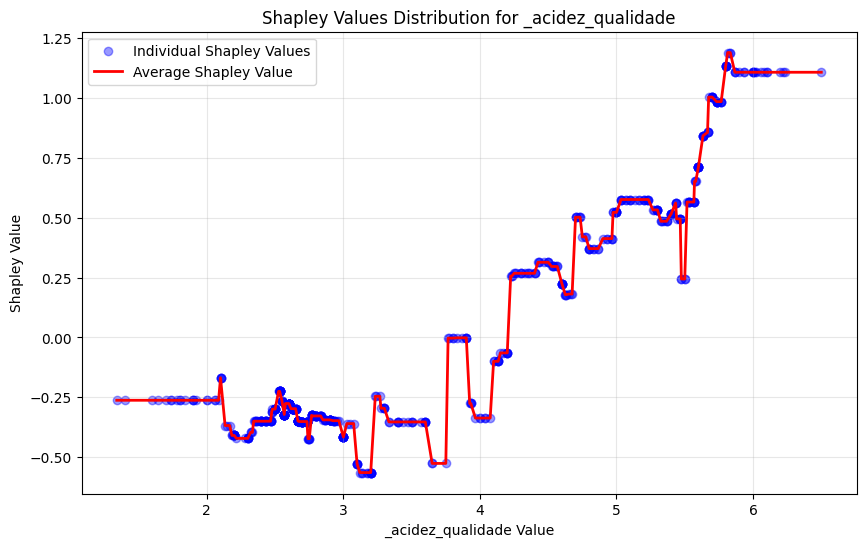

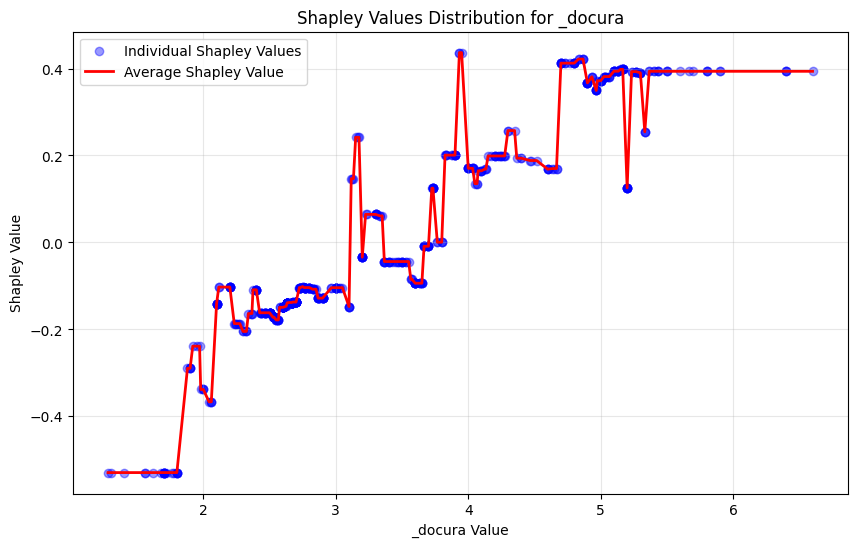

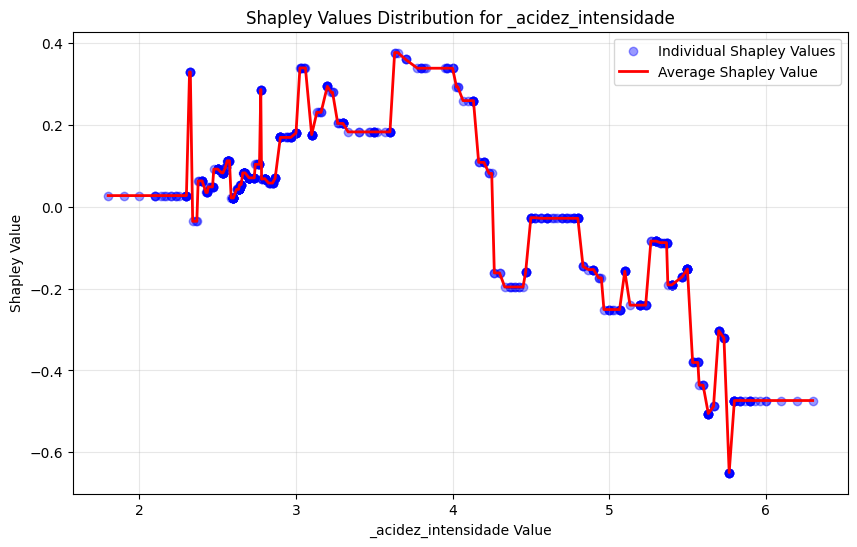

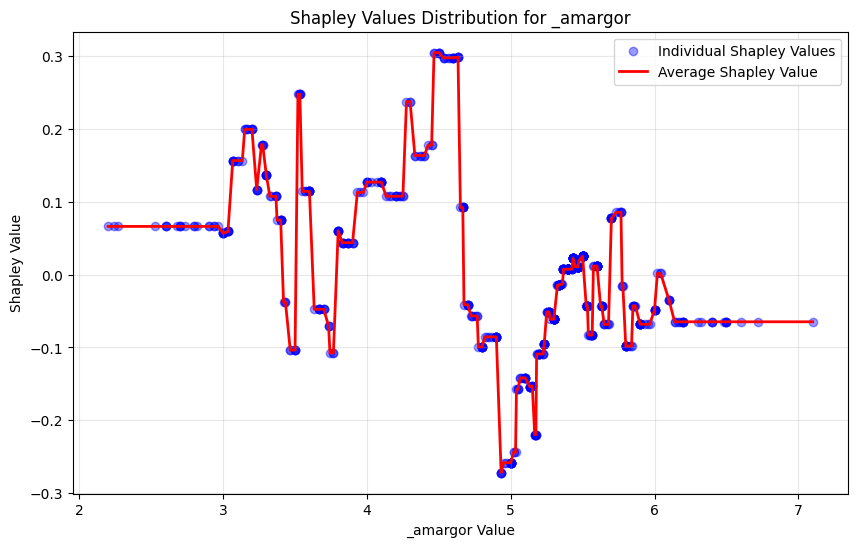

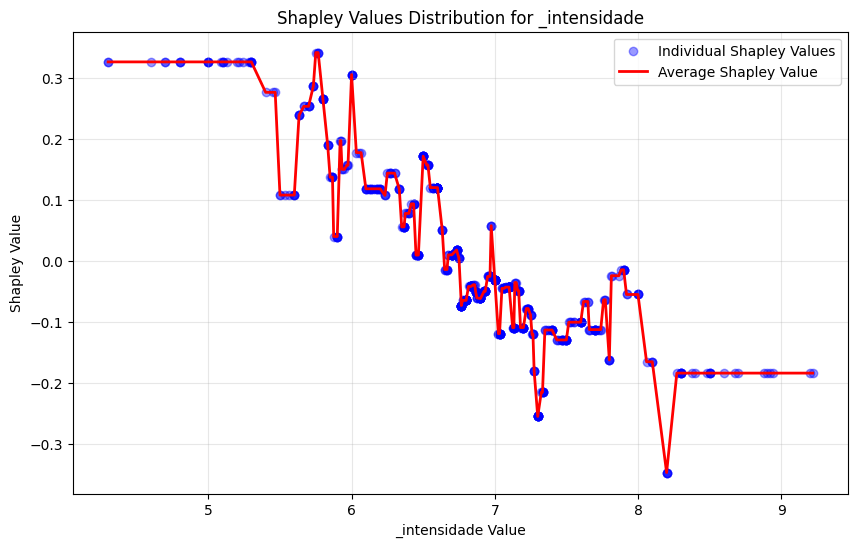

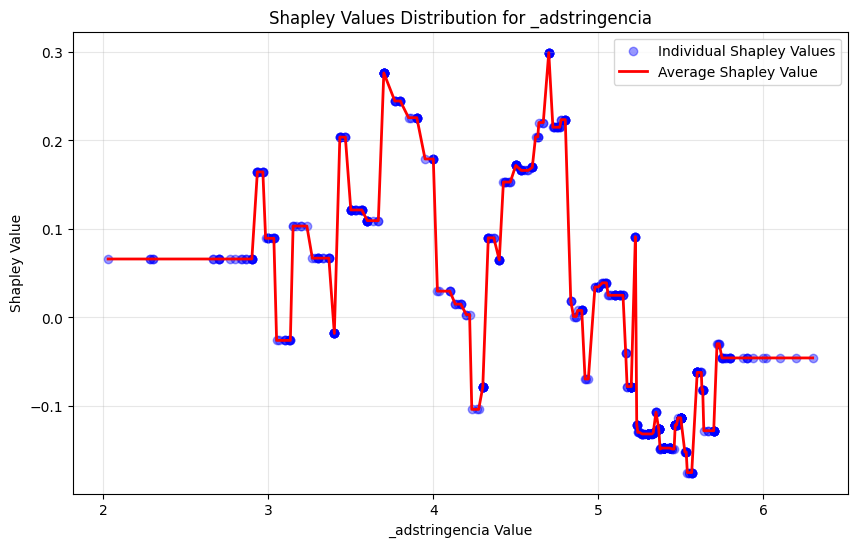

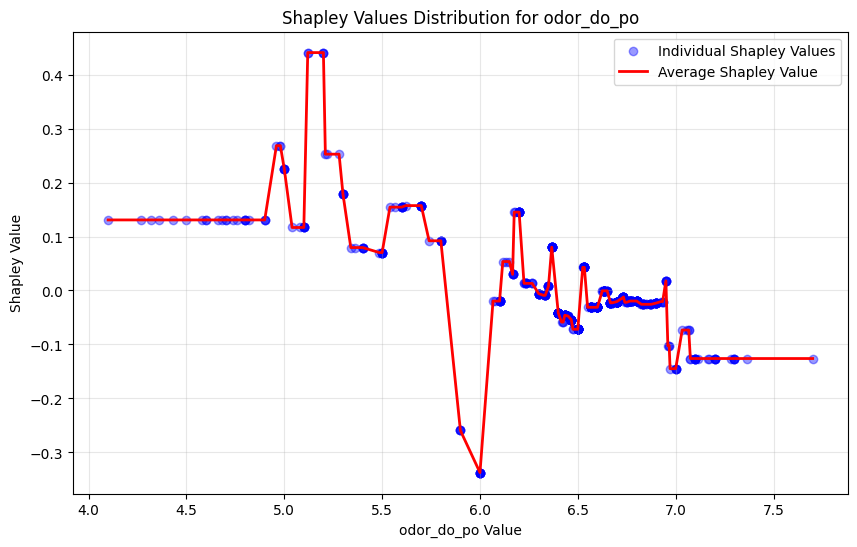

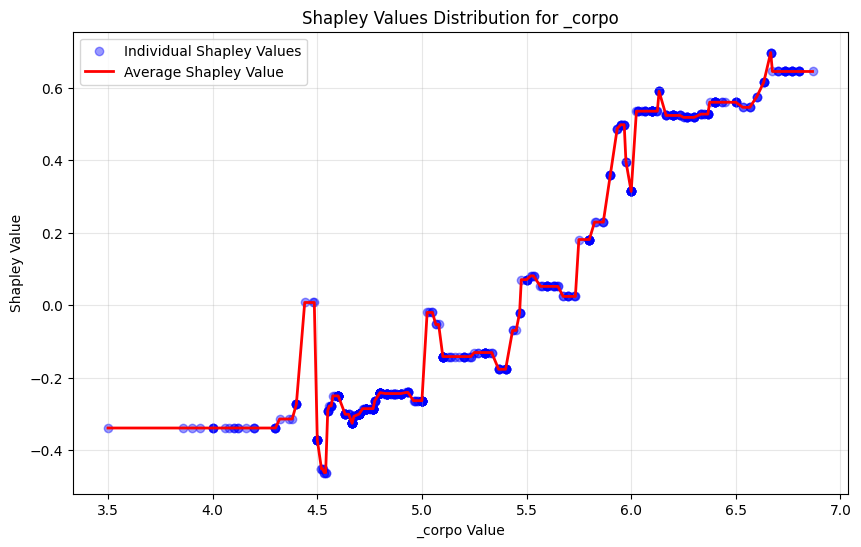

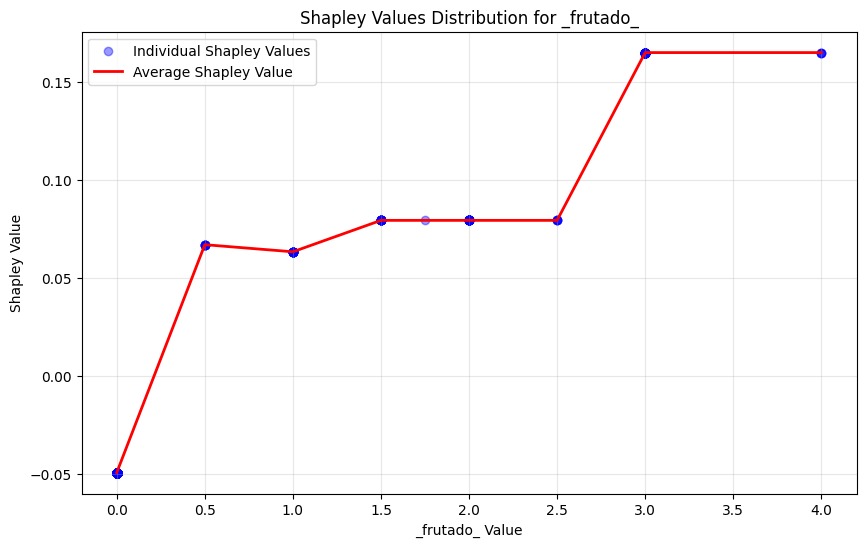

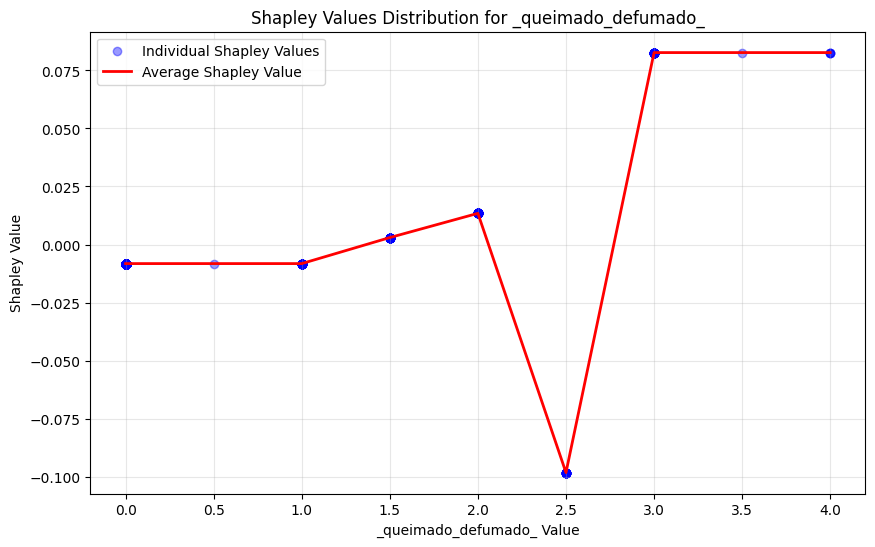

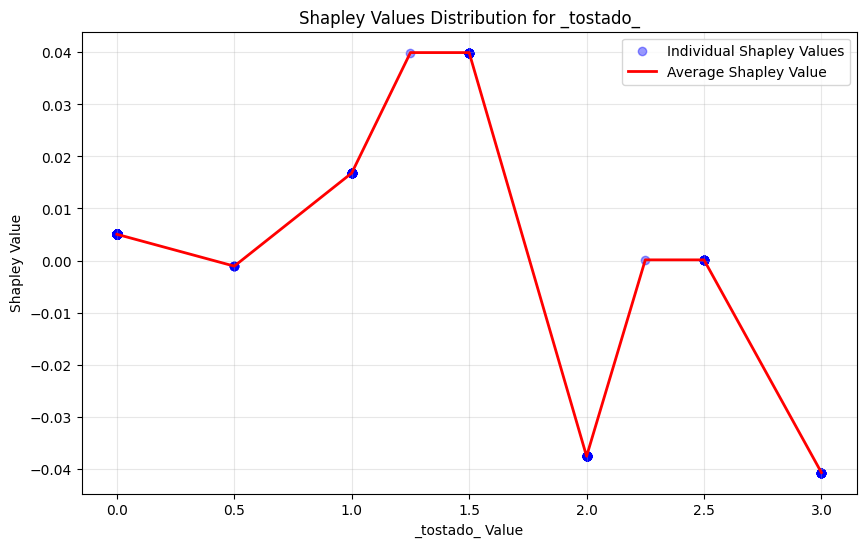

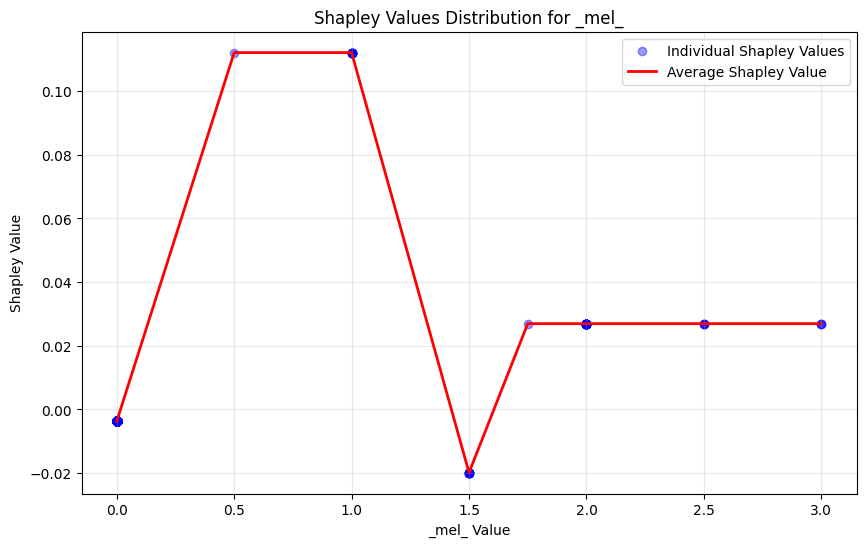

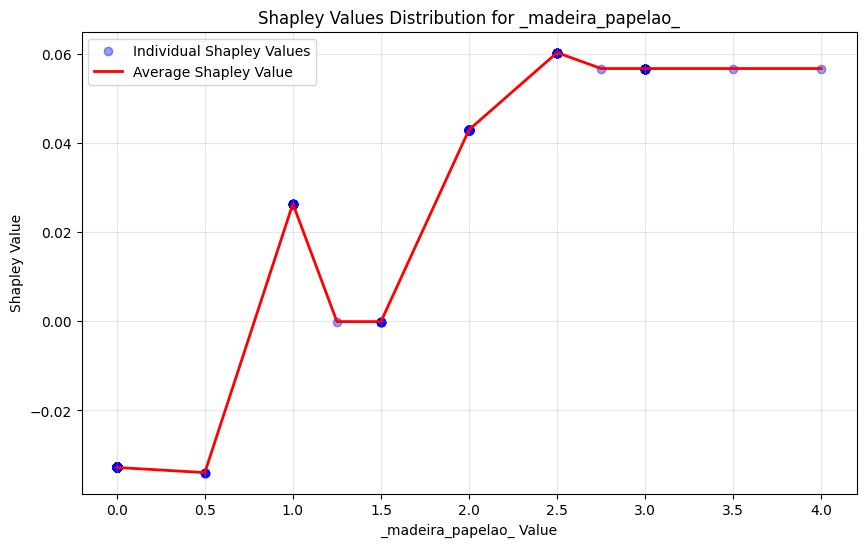

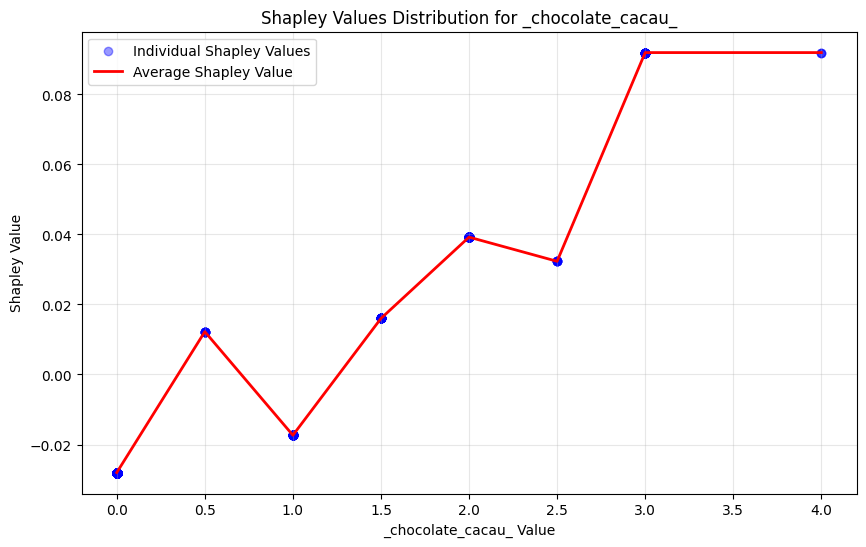

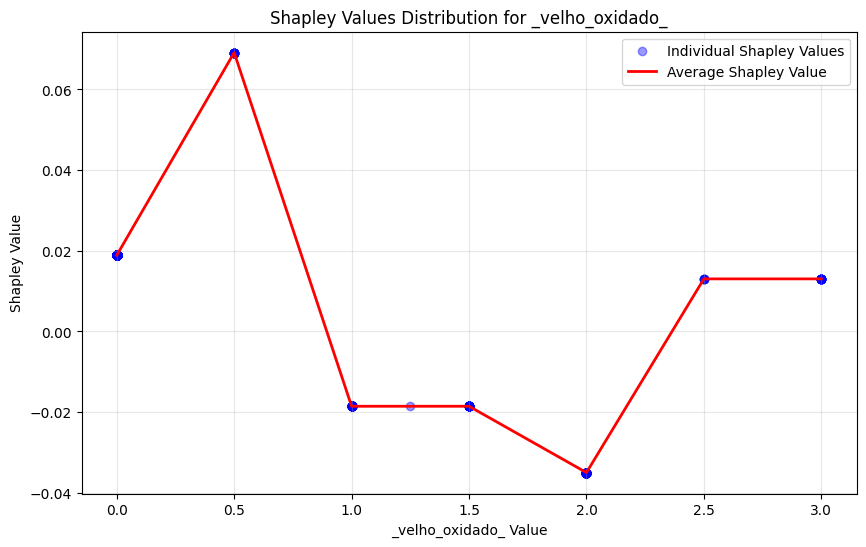

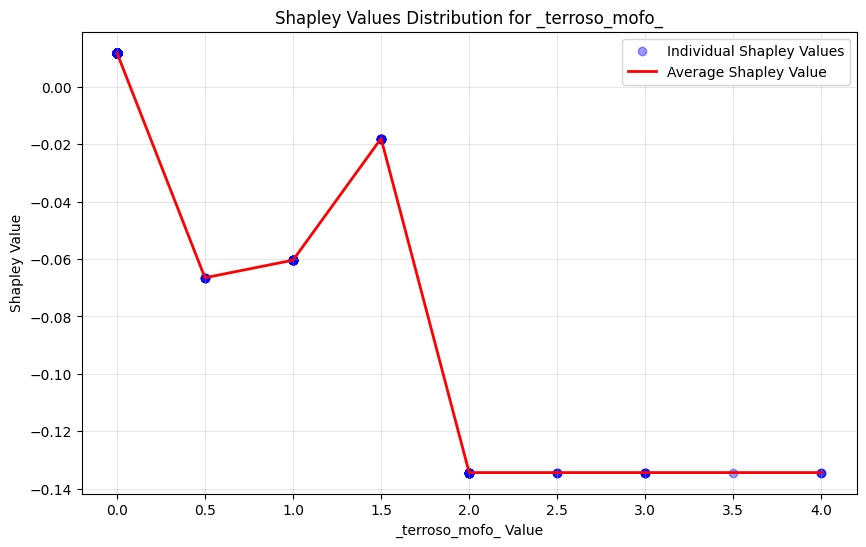

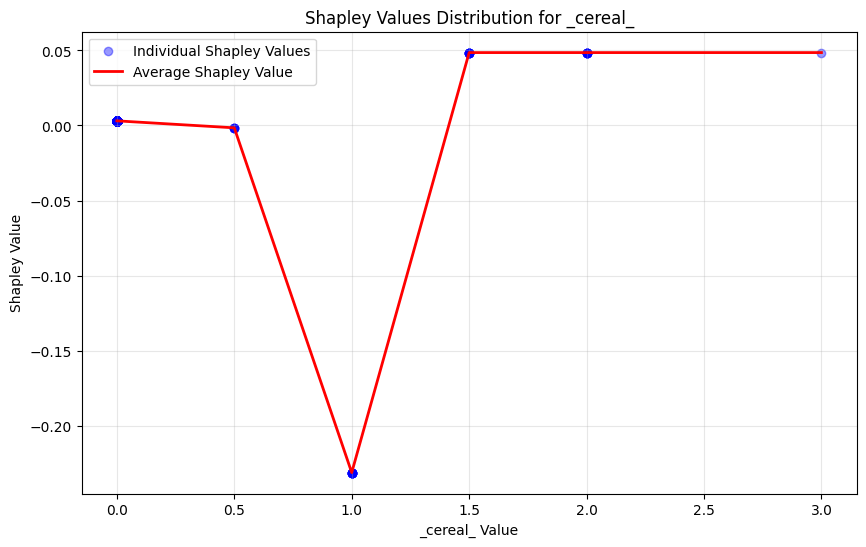

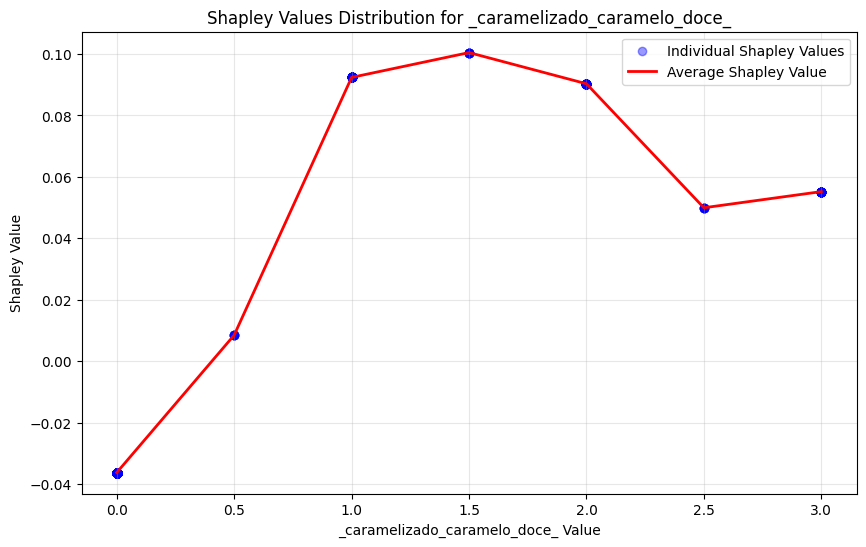

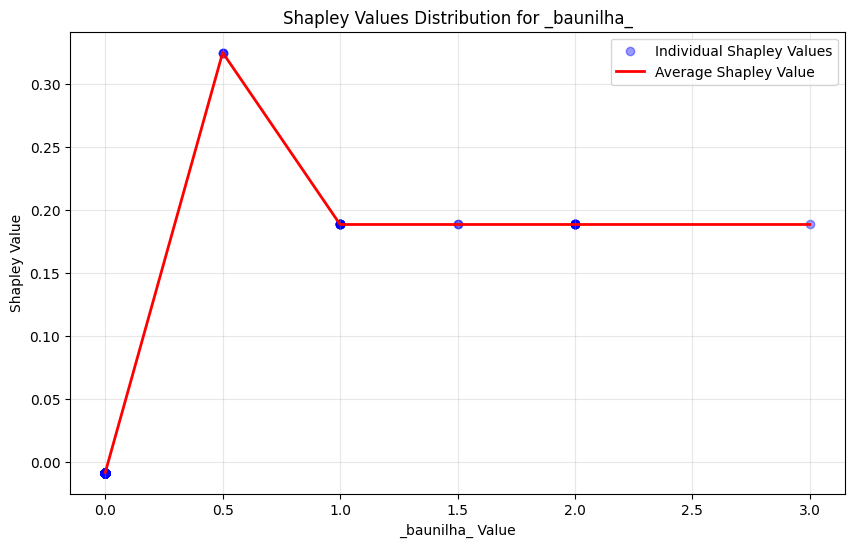

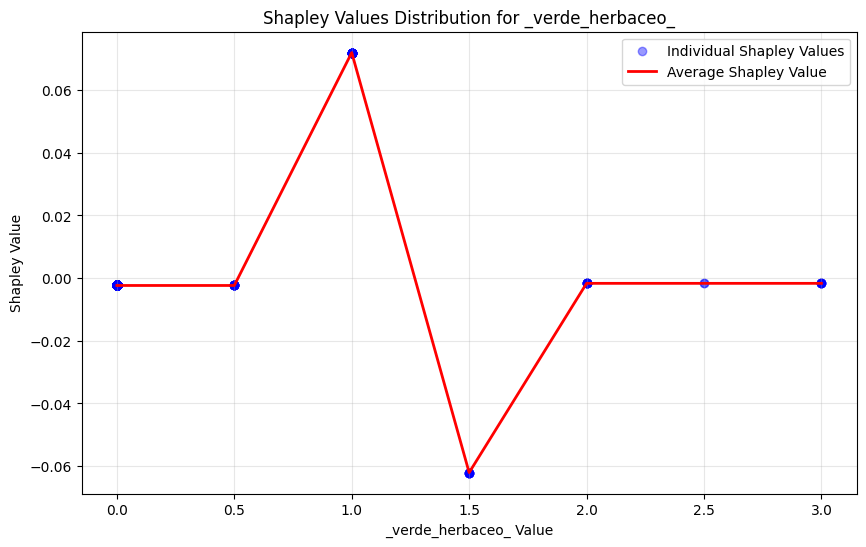

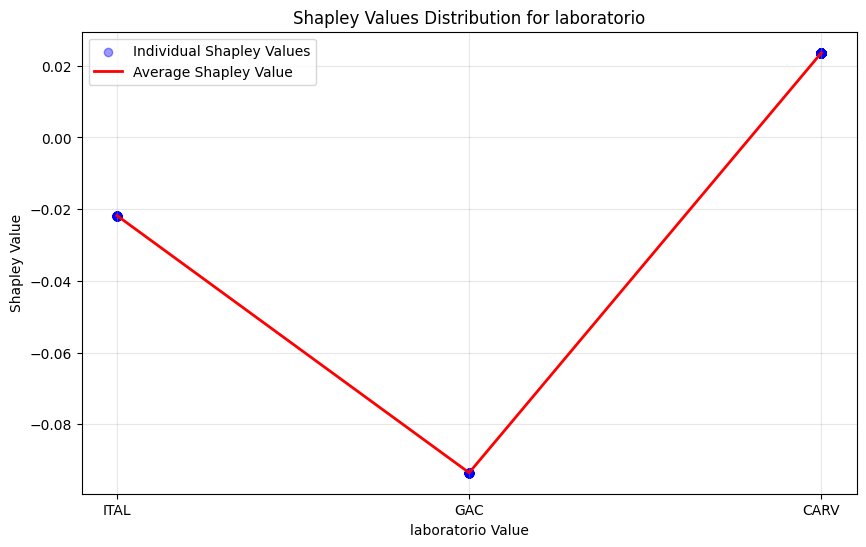

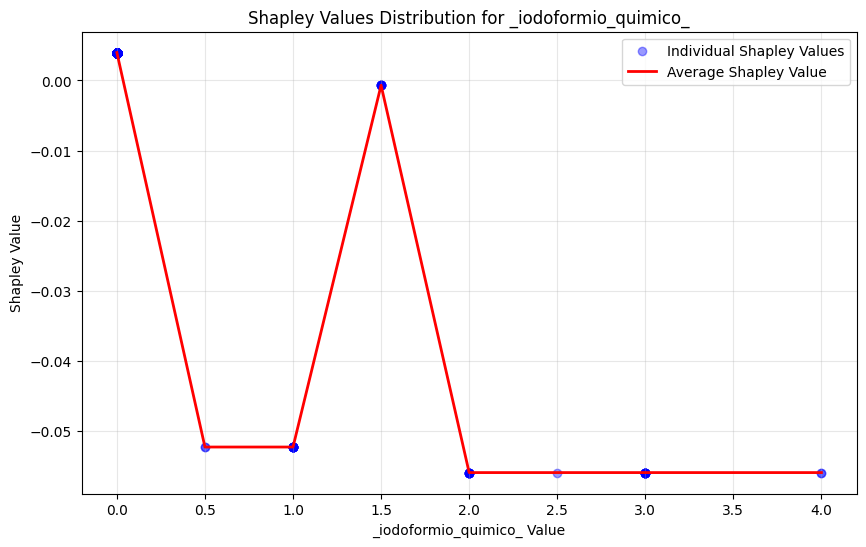

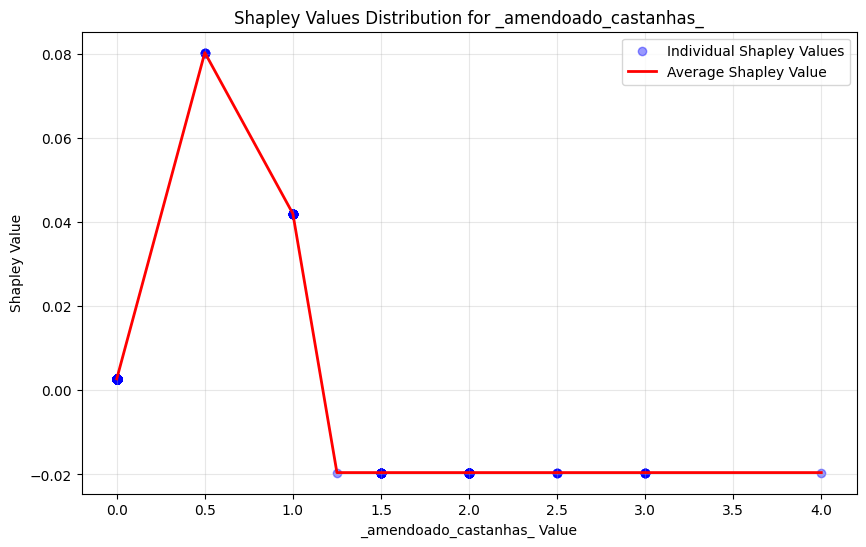

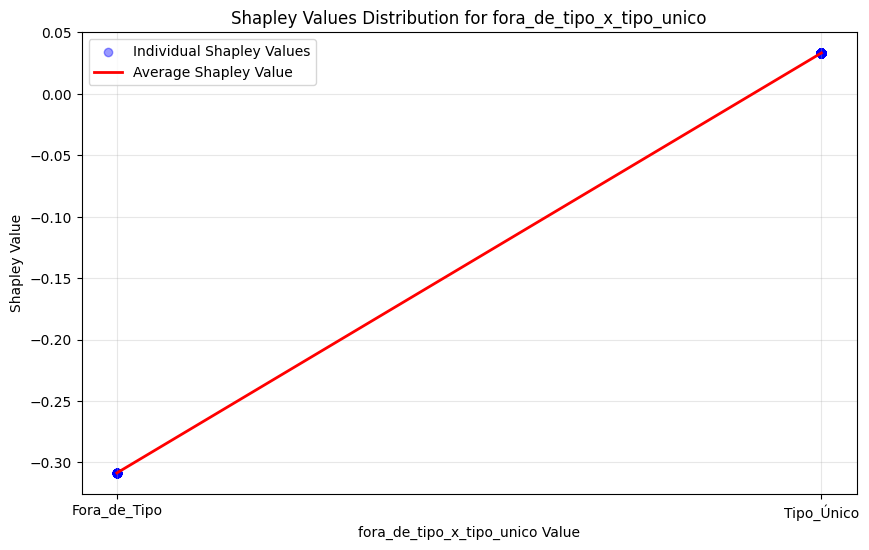

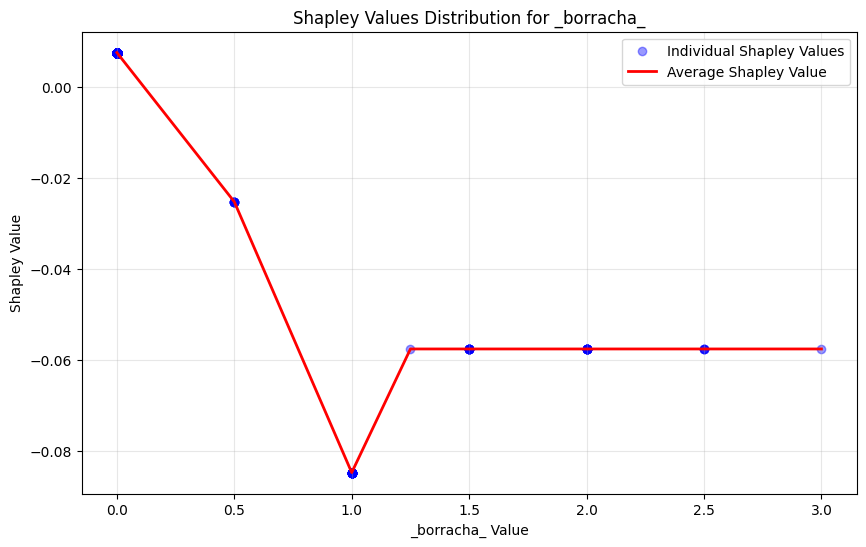

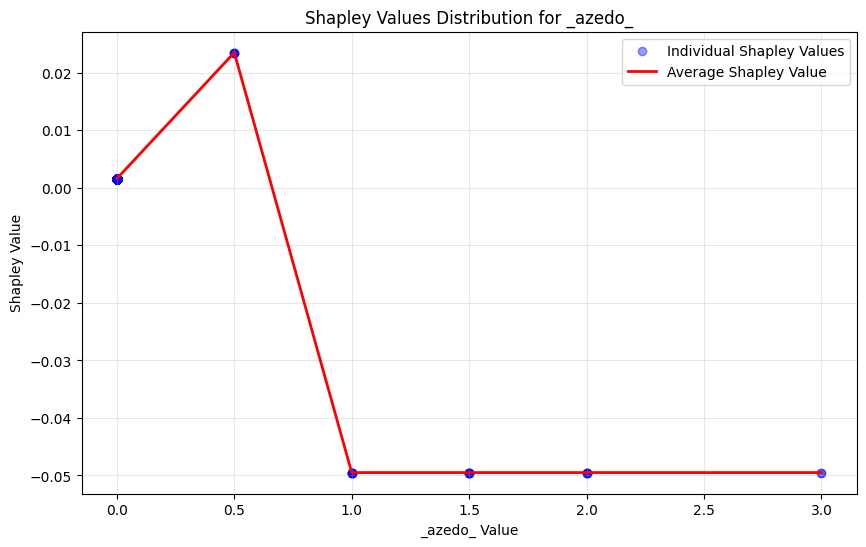

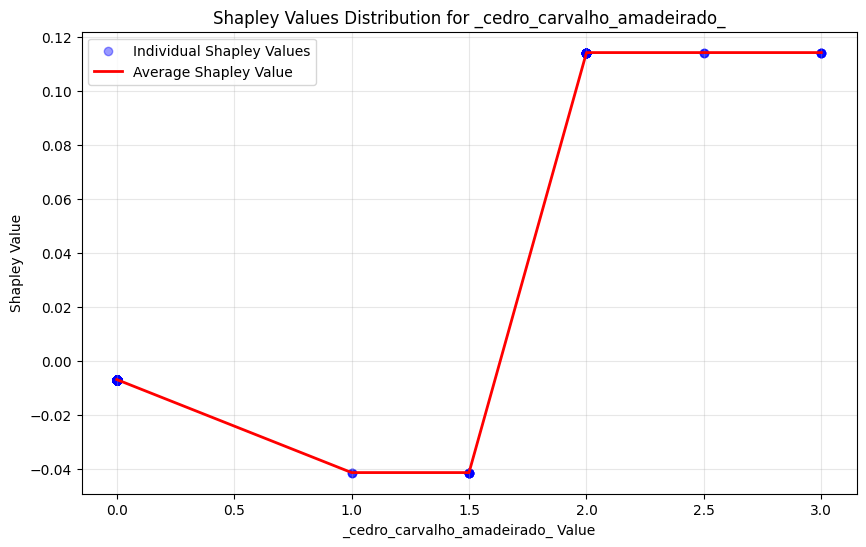

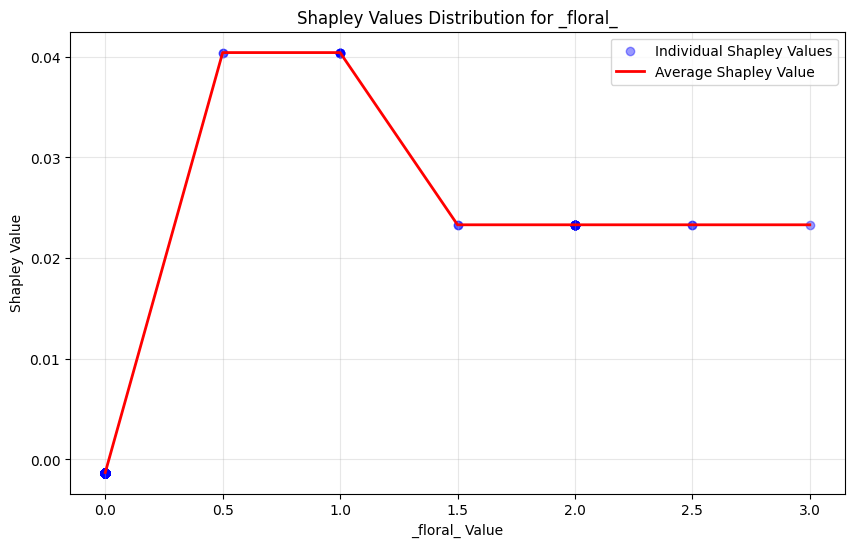

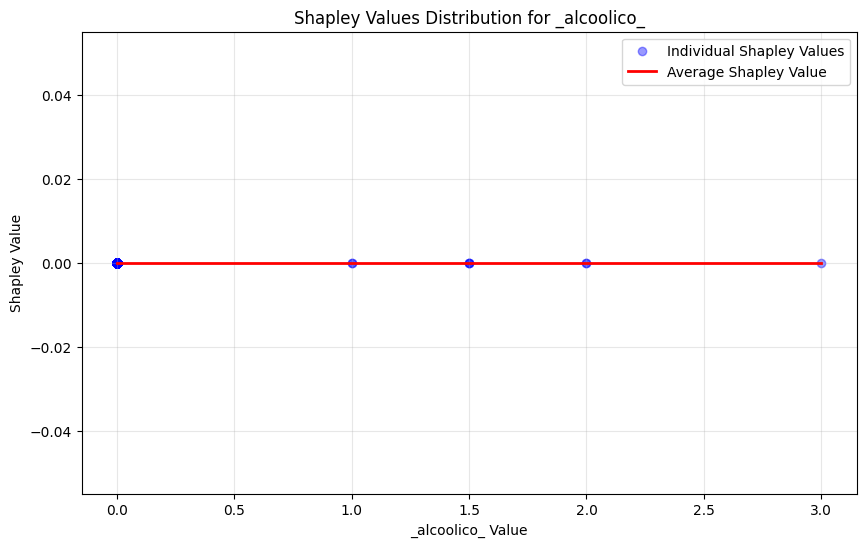

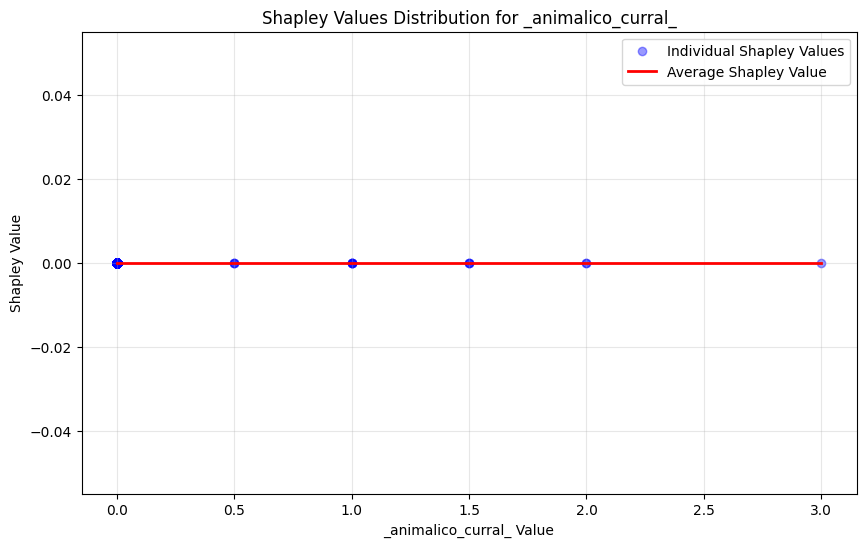

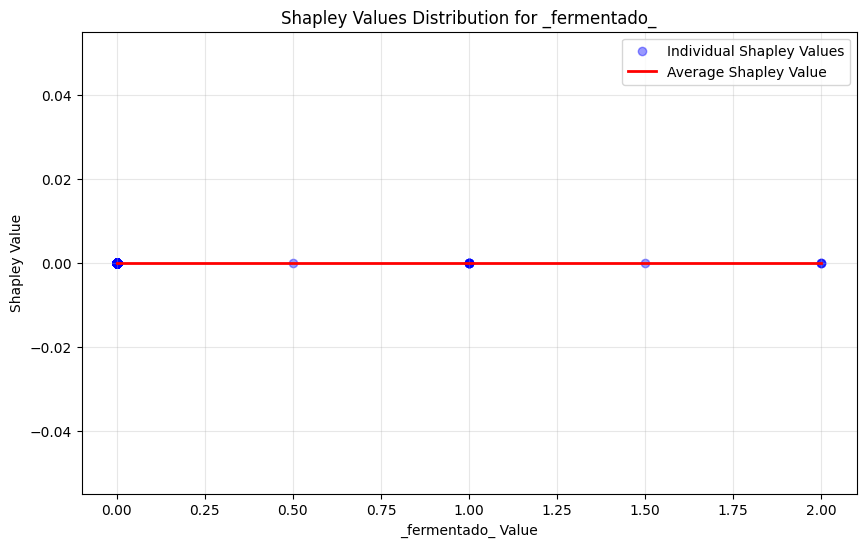

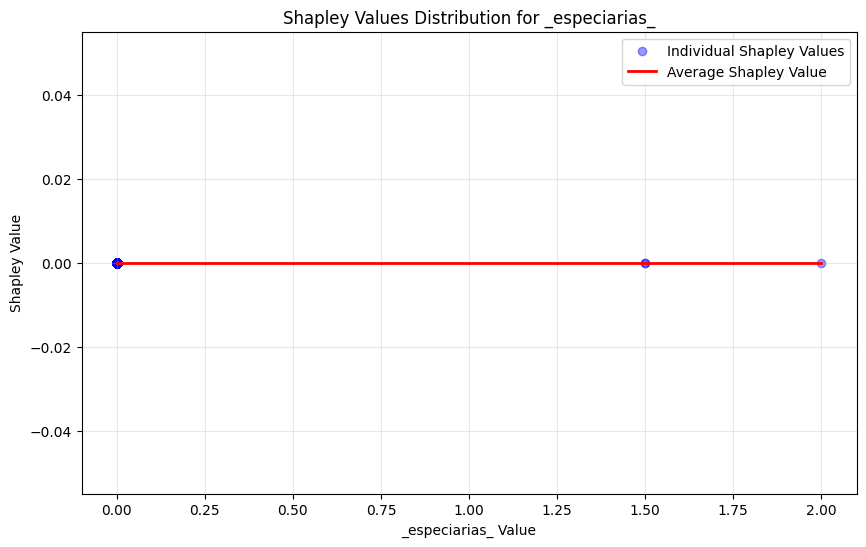

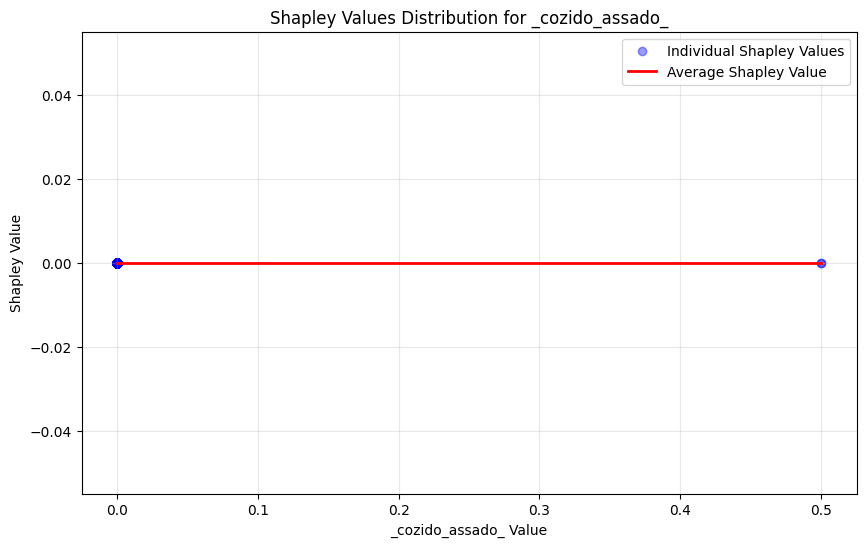

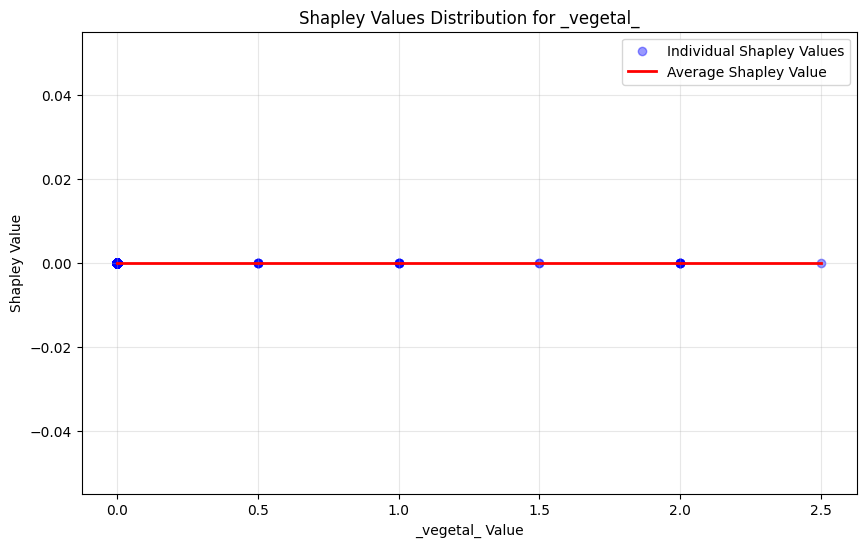

In [15]:
from func import plot_shapley_values

for name in main_imp.index.values:
    plot_shapley_values(shap_df,trn_data ,name)


# <a id='toc7_'></a>[Interaction analysis](#toc0_)

In [16]:
est_data = trn_data.copy()
for cat_var in categorical_features:
    est_data[cat_var] = est_data[cat_var].cat.codes


In [17]:
from shap.utils import approximate_interactions
import shap

exp = TreeExplainer(int_mdl)
shap_interaction_values = exp.shap_interaction_values(est_data)
shap_vals = exp.shap_values(trn_data)


shap_df = pd.DataFrame(shap_vals, columns=trn_data.columns)
int_order = {}

for col in trn_data.columns:
   int_order[col] = approximate_interactions(index=col, shap_values=shap_vals, X=trn_data, feature_names=trn_data.columns)



## <a id='toc7_1_'></a>[Main interactions](#toc0_)

In [18]:
tbl = dict()
for col in int_imp.index.values:

    int_vars = [trn_data.columns[int_order[col][i]] for i in range(3)]
    tbl[col]=int_vars

tbl = pd.DataFrame(tbl).transpose()
tbl.index.name = "Feature"
tbl.columns = ["Top 1 interaction", "Top 2 interaction", "Top 3 interaction"]
tbl

Top 1 interaction  \
Feature                                                      
_intensidade                           _acidez_intensidade   
odor_do_po                             _queimado_defumado_   
_chocolate_cacau_                                _tostado_   
_amargor                               _acidez_intensidade   
_velho_oxidado_                          _madeira_papelao_   
_corpo                                           _tostado_   
_queimado_defumado_                    _acidez_intensidade   
_adstringencia                                 laboratorio   
_acidez_intensidade                           _intensidade   
_madeira_papelao_                fora_de_tipo_x_tipo_unico   
_acidez_qualidade                             _intensidade   
_docura                                     _adstringencia   
_tostado_                                _chocolate_cacau_   
laboratorio                                        _docura   
fora_de_tipo_x_tipo_unico                       odor_do_po   
_frutado_                                _chocolate_cacau_   
_caramelizado_caramelo_doce_         _amendoado_castanhas_   
_terroso_mofo_                           _acidez_qualidade   
_iodoformio_quimico_                          _intensidade   
_verde_herbaceo_                         _madeira_papelao_   
_borracha_                               _madeira_papelao_   
_mel_                                    _chocolate_cacau_   
_amendoado_castanhas_                            _tostado_   
_cedro_carvalho_amadeirado_            _acidez_intensidade   
_cereal_                                           _docura   
_floral_                      _caramelizado_caramelo_doce_   
_baunilha_                                  _adstringencia   
_azedo_                                _acidez_intensidade   
_alcoolico_                                    laboratorio   
_animalico_curral_                             laboratorio   
_fermentado_                                   laboratorio   
_especiarias_                                  laboratorio   
_cozido_assado_                                laboratorio   
_vegetal_                                      laboratorio   

                                      Top 2 interaction  \
Feature                                                   
_intensidade                          _acidez_qualidade   
odor_do_po                    fora_de_tipo_x_tipo_unico   
_chocolate_cacau_                          _intensidade   
_amargor                              _acidez_qualidade   
_velho_oxidado_                     _acidez_intensidade   
_corpo                                      laboratorio   
_queimado_defumado_                   _acidez_qualidade   
_adstringencia                        _chocolate_cacau_   
_acidez_intensidade                   _acidez_qualidade   
_madeira_papelao_                        _terroso_mofo_   
_acidez_qualidade                           laboratorio   
_docura                                        _amargor   
_tostado_                                        _corpo   
laboratorio                           _acidez_qualidade   
fora_de_tipo_x_tipo_unico               _velho_oxidado_   
_frutado_                                       _docura   
_caramelizado_caramelo_doce_          _chocolate_cacau_   
_terroso_mofo_                      _acidez_intensidade   
_iodoformio_quimico_                  _chocolate_cacau_   
_verde_herbaceo_                    _queimado_defumado_   
_borracha_                          _acidez_intensidade   
_mel_                                        odor_do_po   
_amendoado_castanhas_                           _docura   
_cedro_carvalho_amadeirado_           _acidez_qualidade   
_cereal_                              _acidez_qualidade   
_floral_                                 _adstringencia   
_baunilha_                                     _amargor   
_azedo_                               _acidez_qualidade   
_alcoolico_                   fora_de_

## <a id='toc7_2_'></a>[Interaction plots](#toc0_)

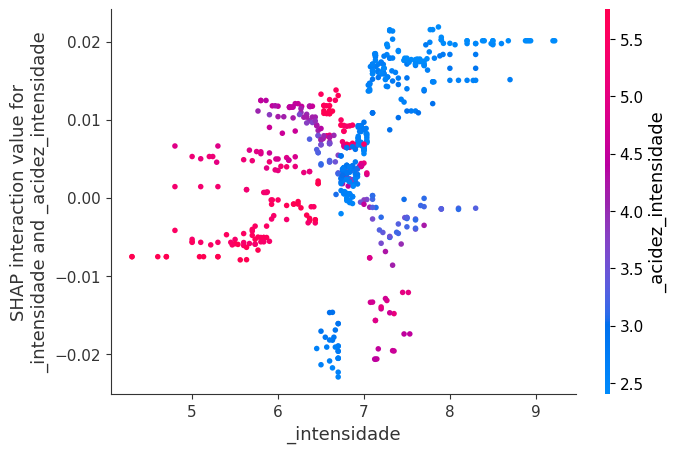

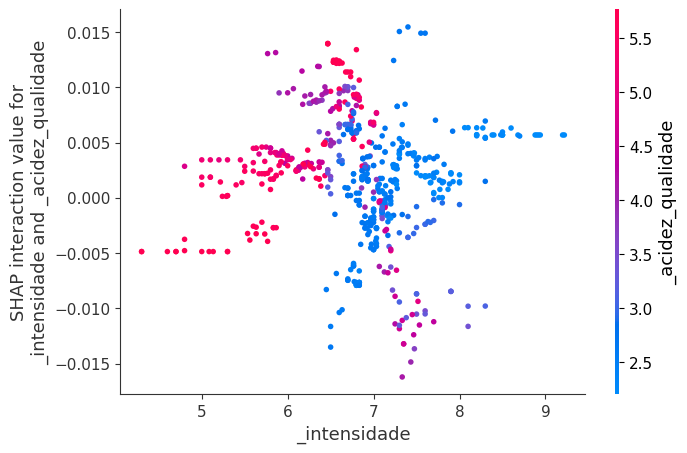

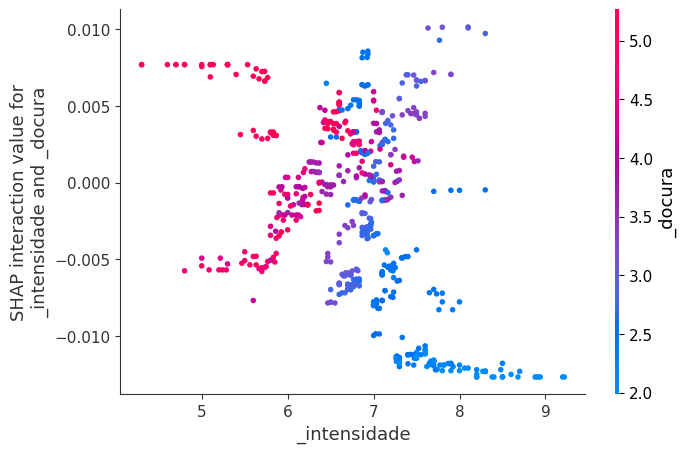

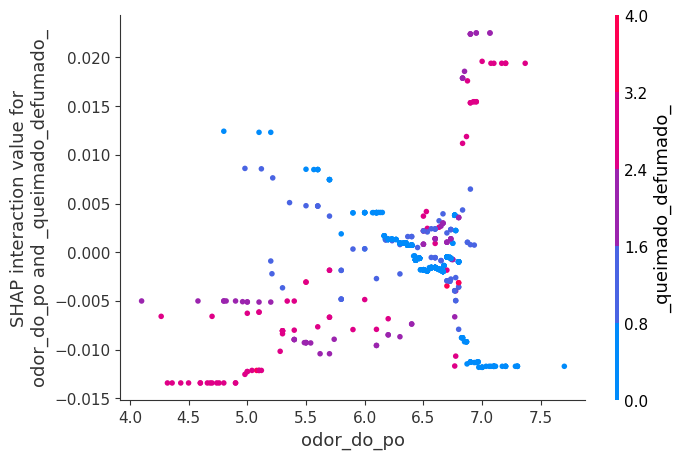

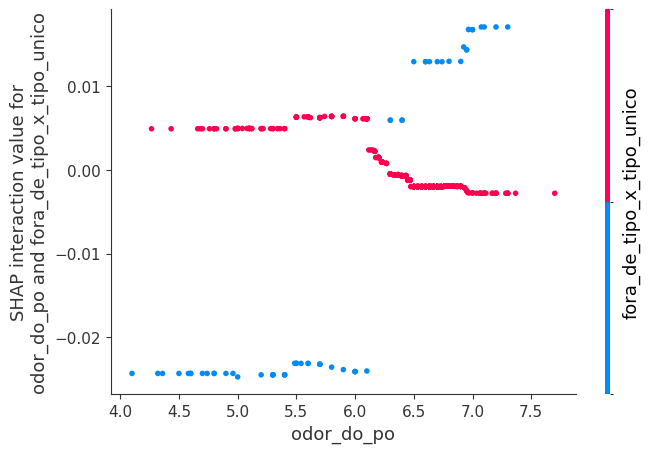

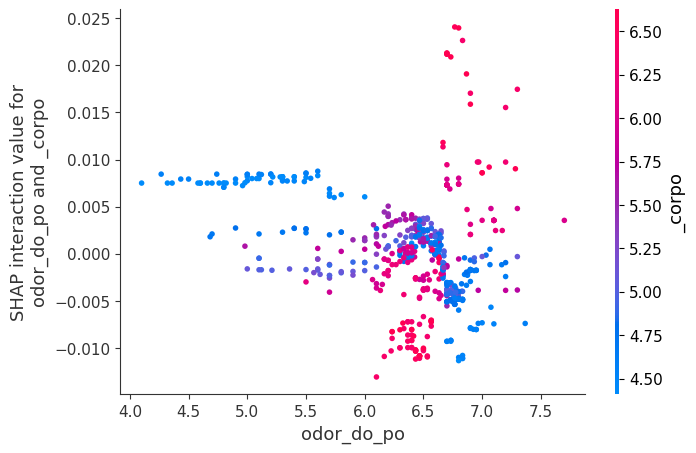

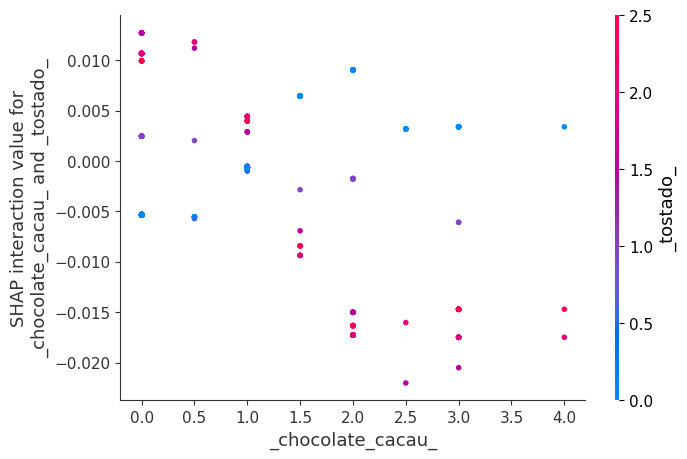

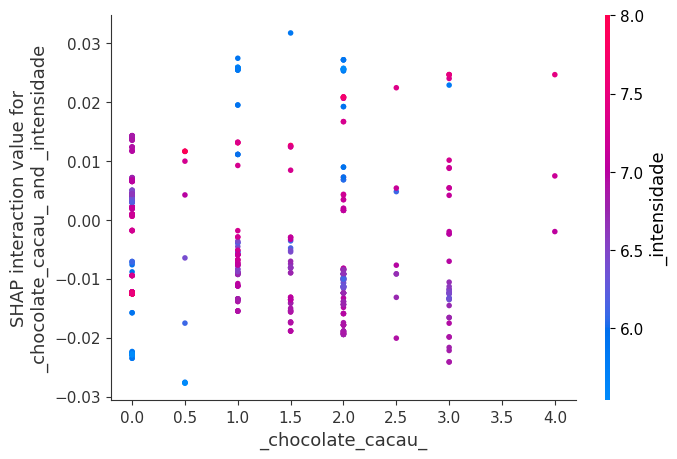

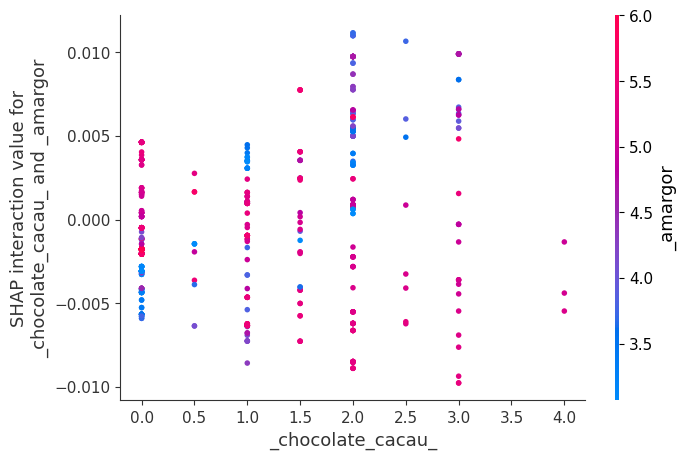

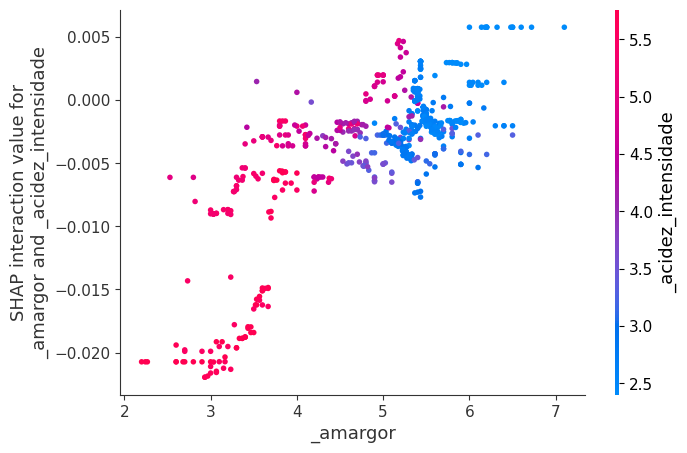

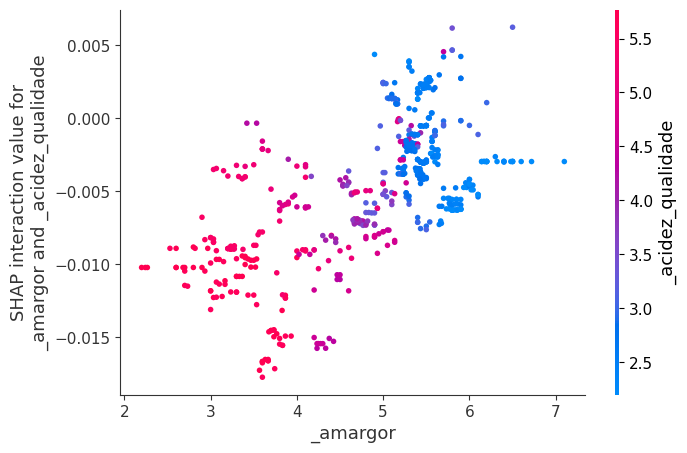

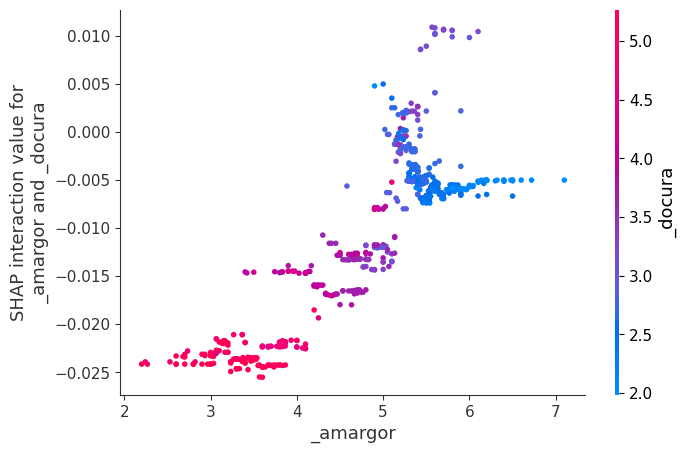

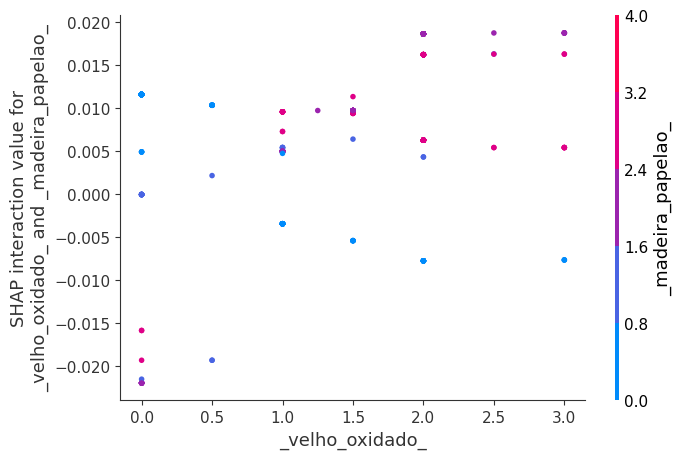

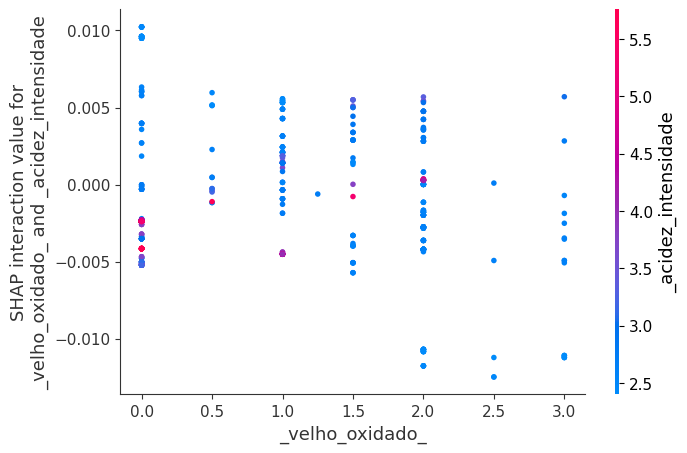

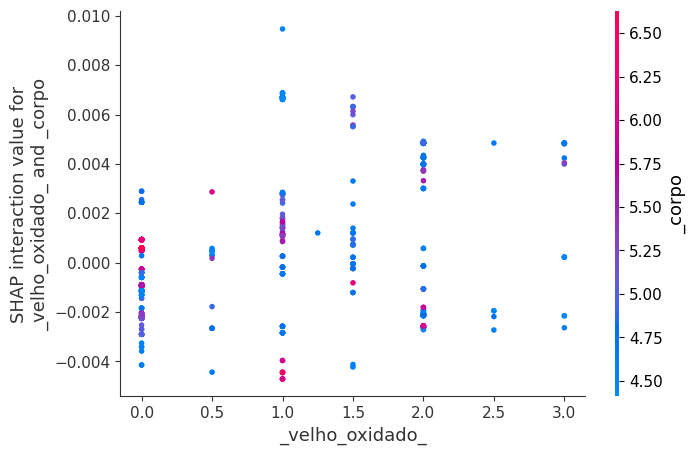

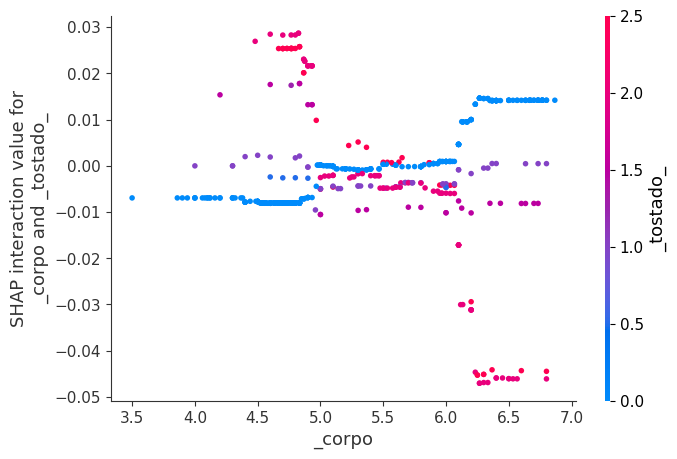

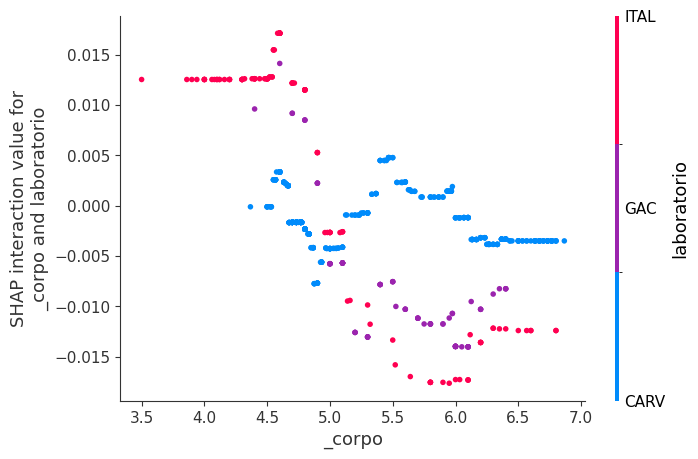

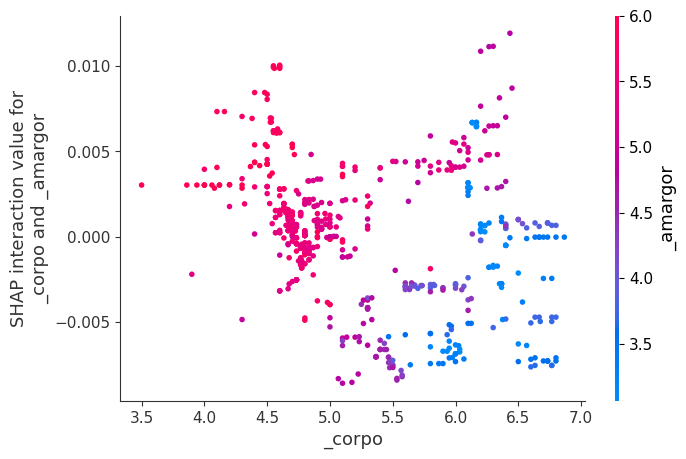

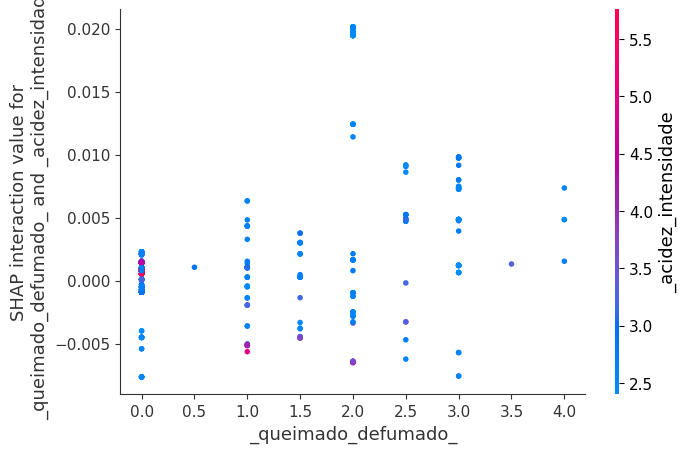

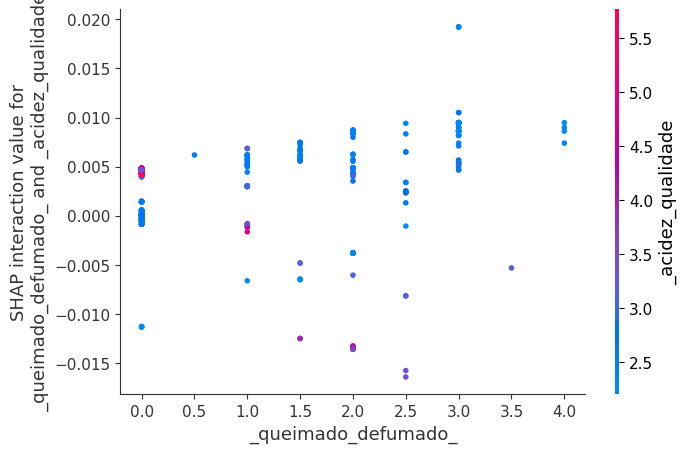

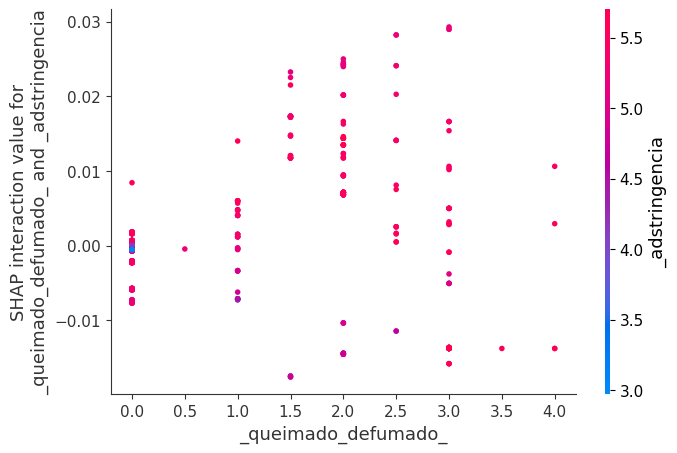

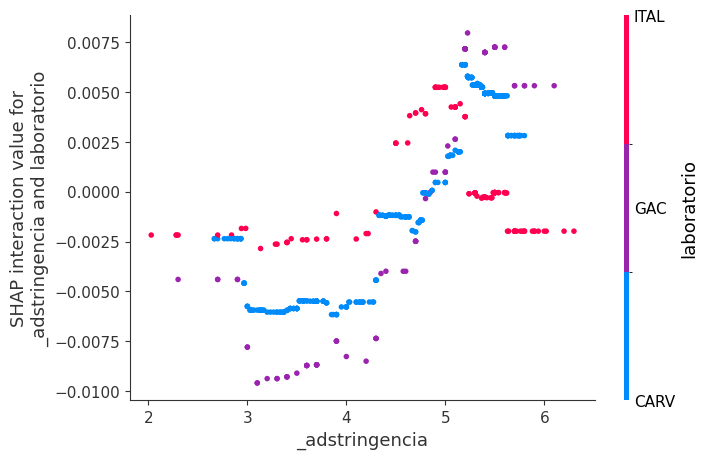

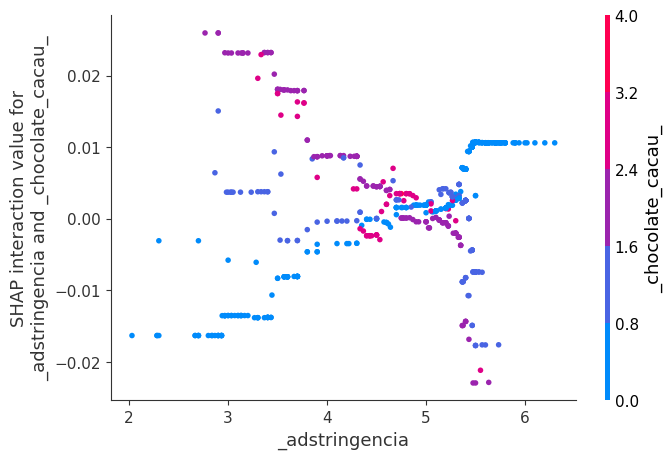

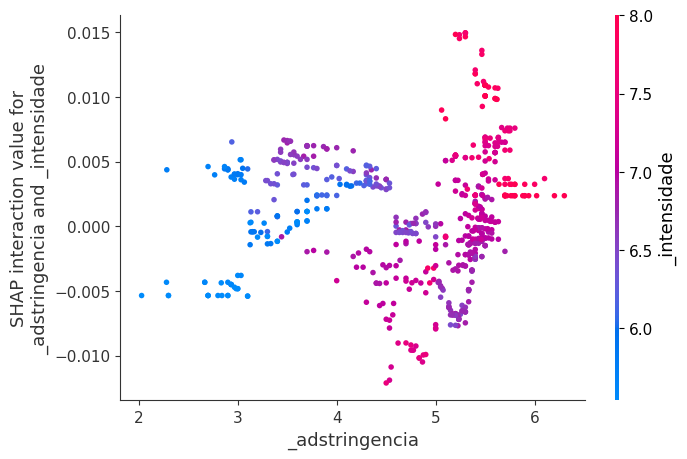

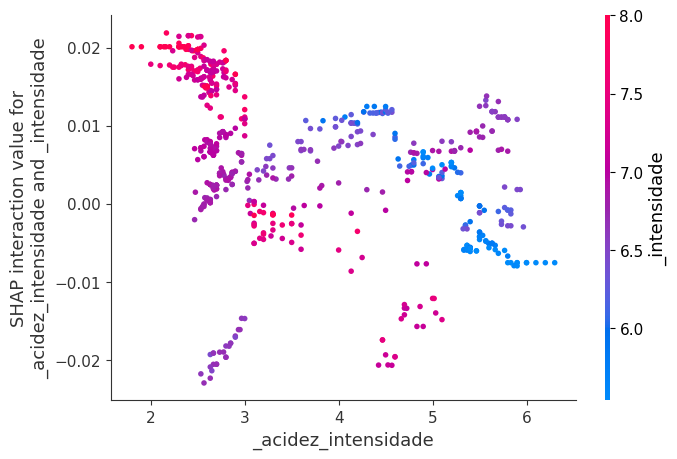

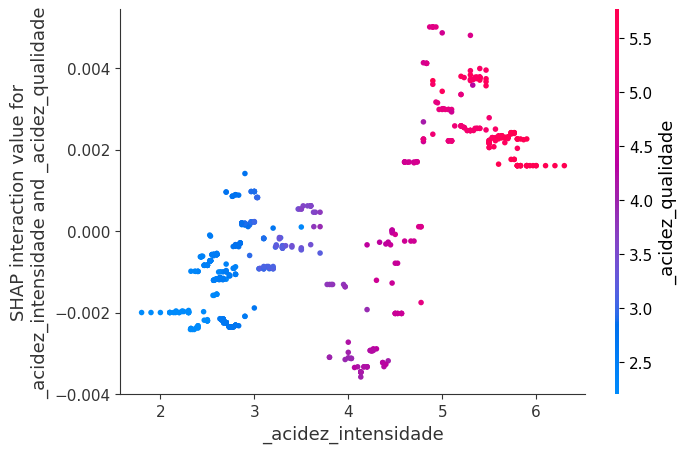

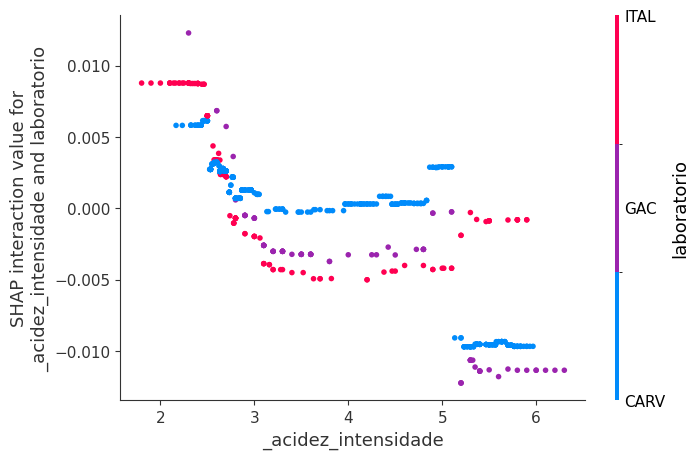

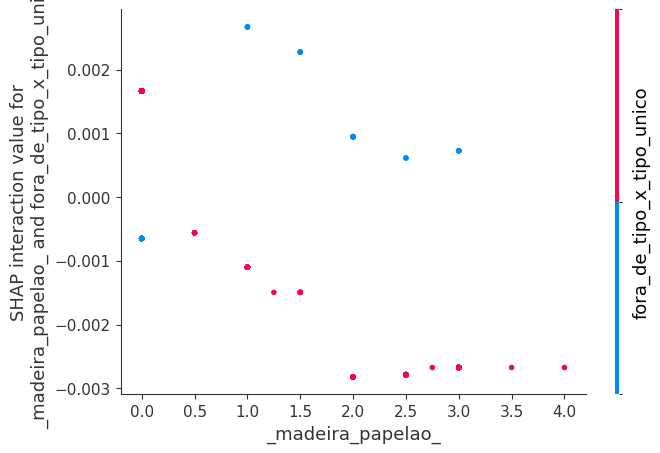

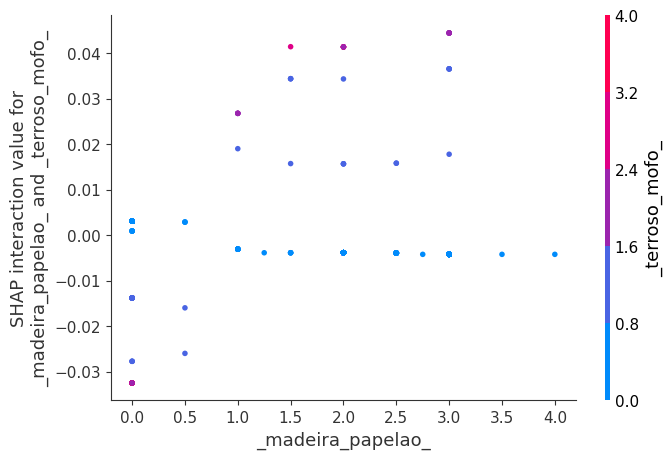

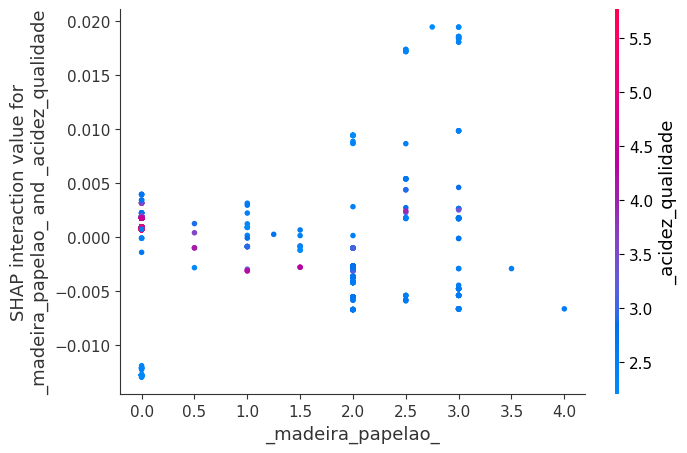

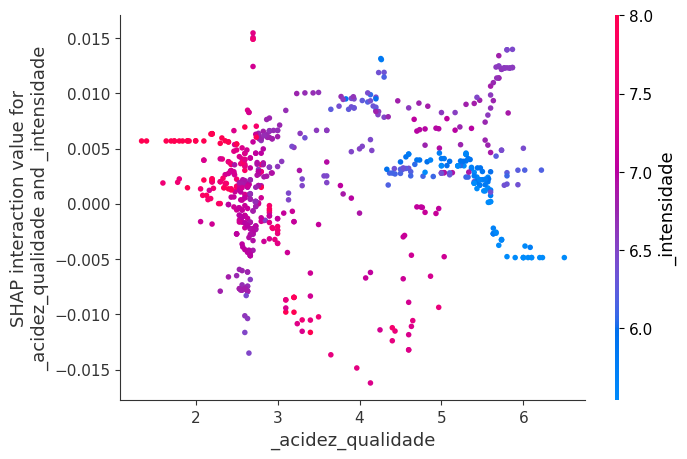

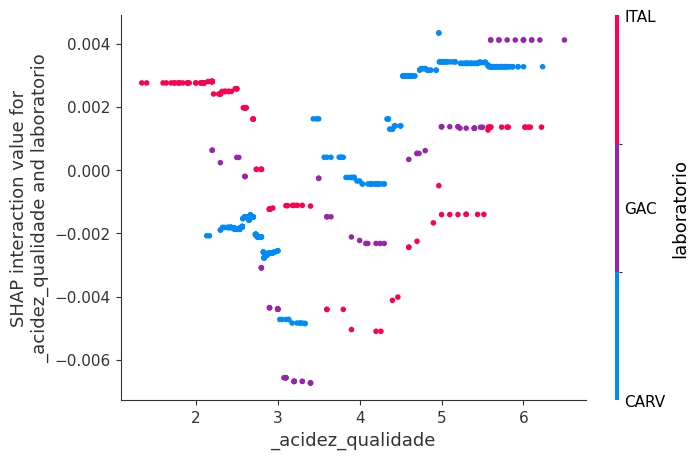

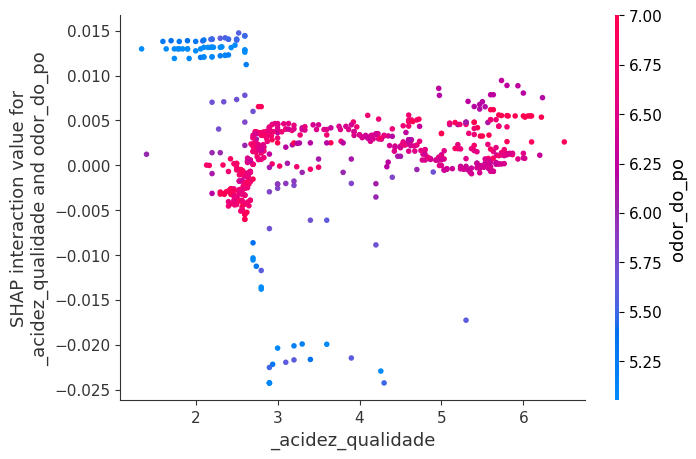

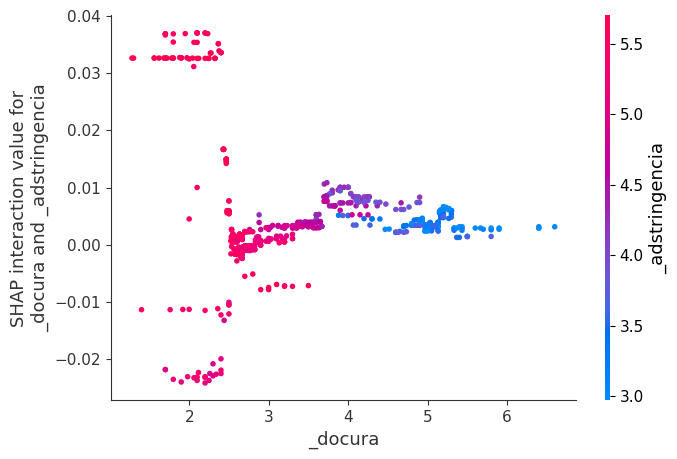

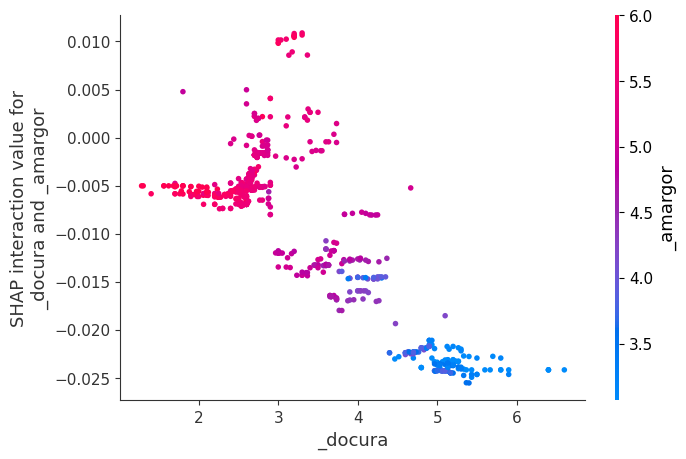

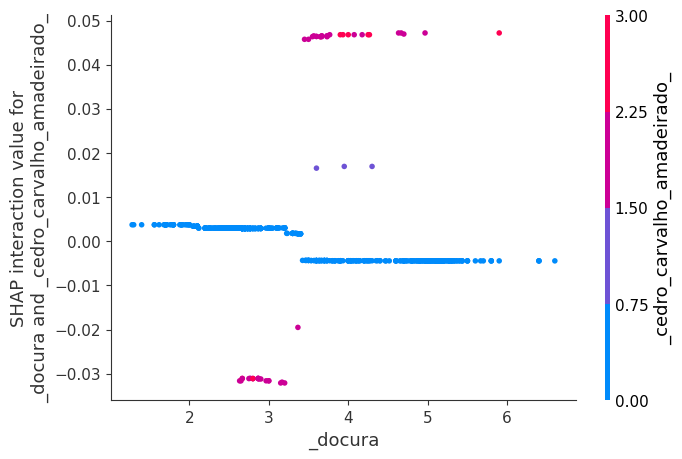

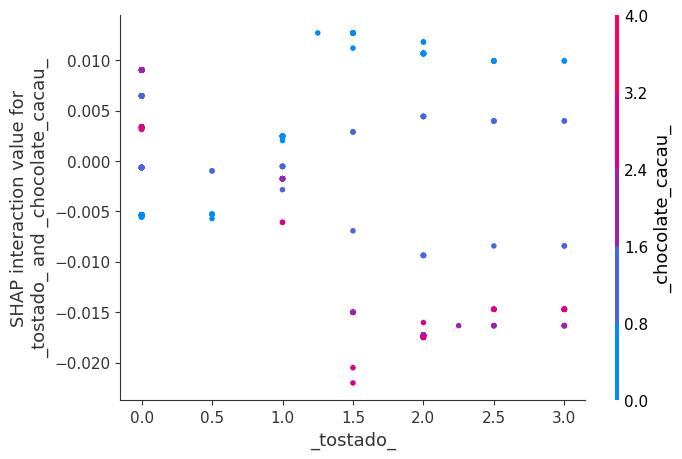

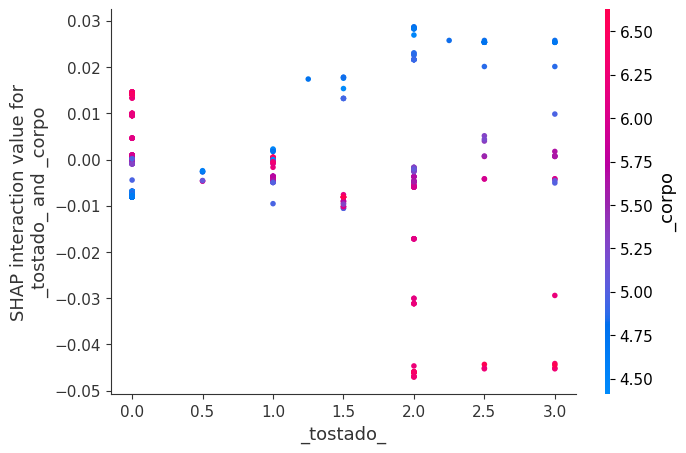

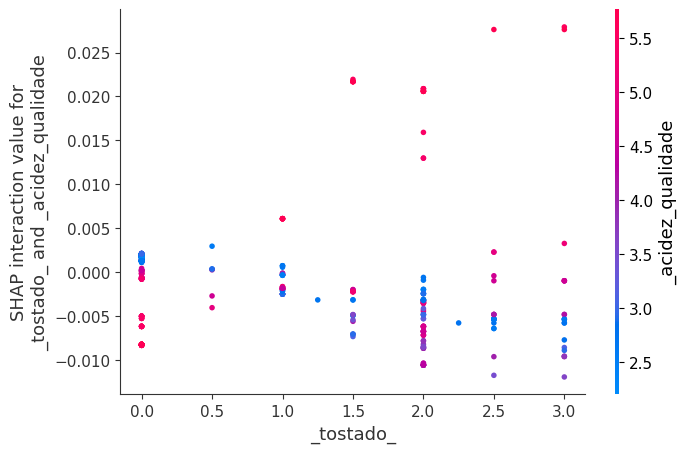

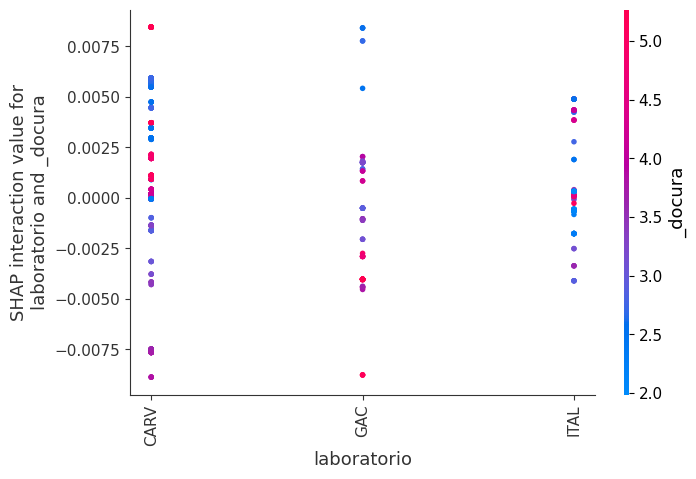

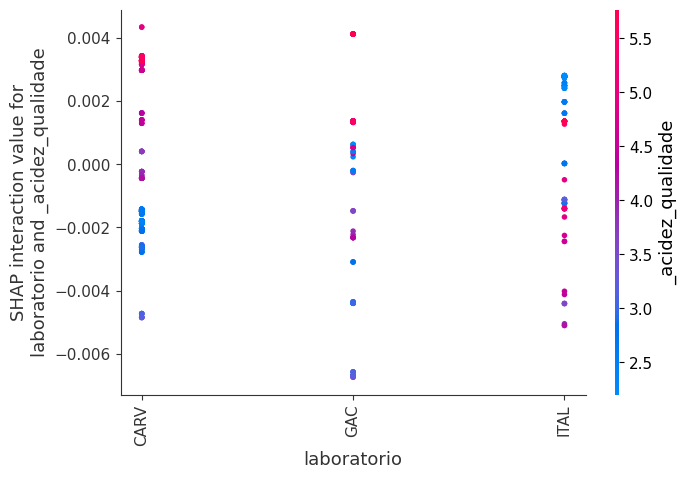

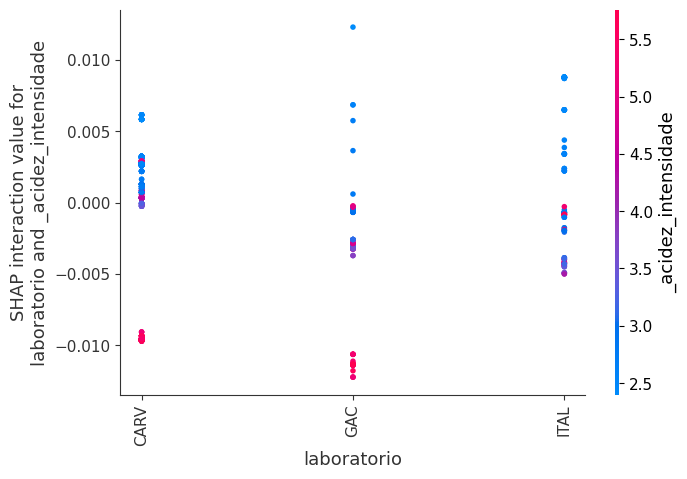

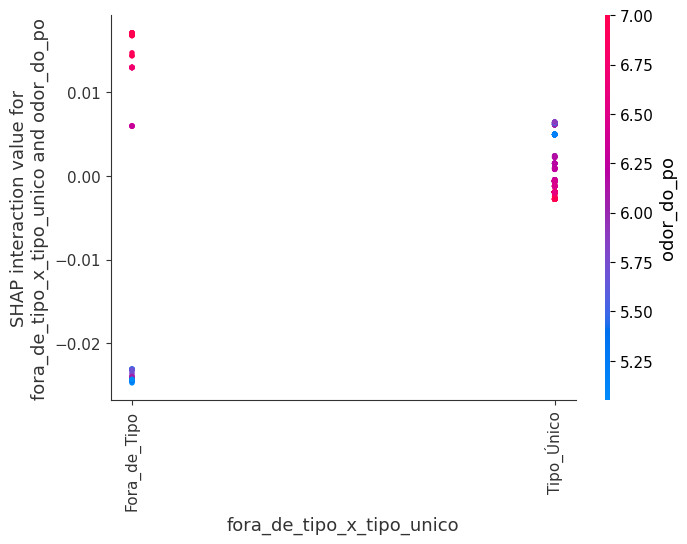

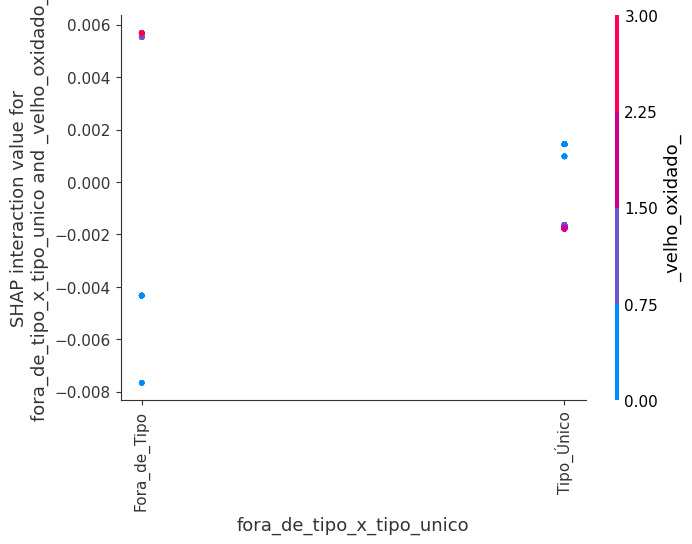

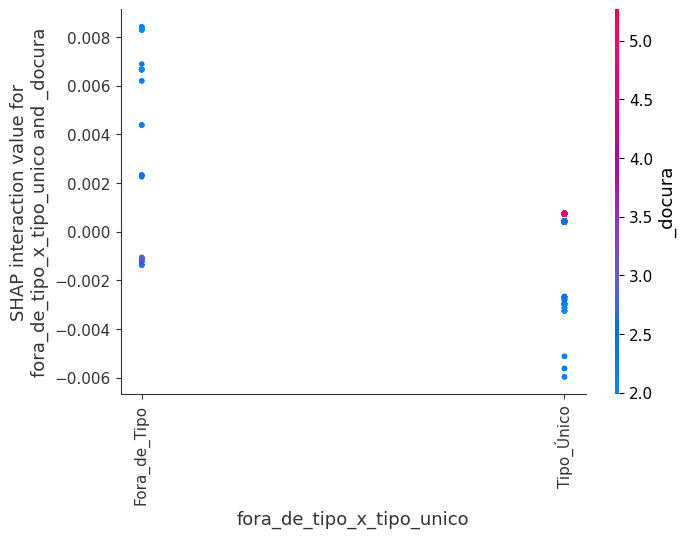

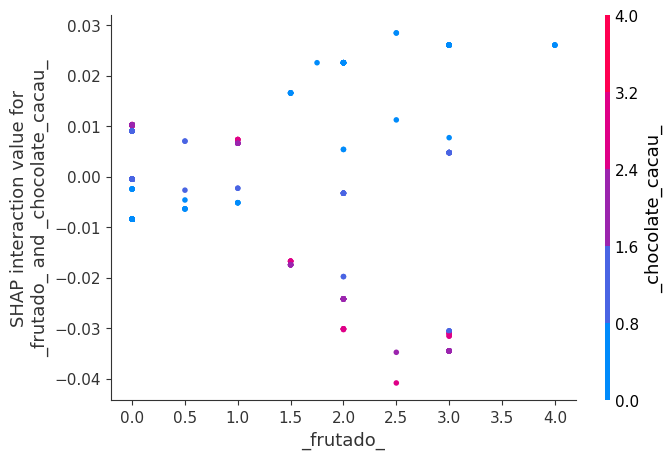

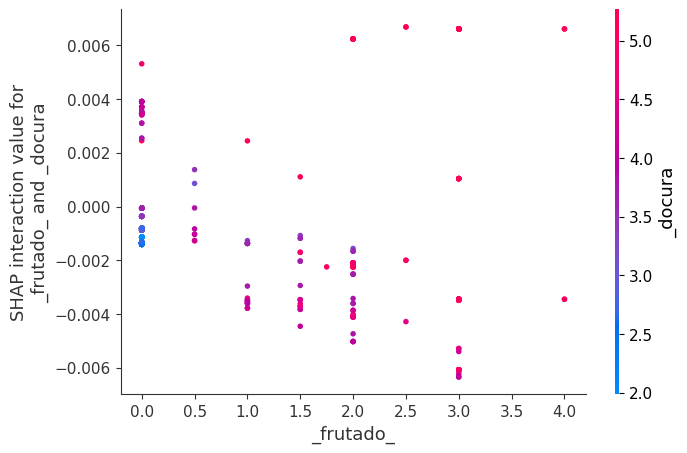

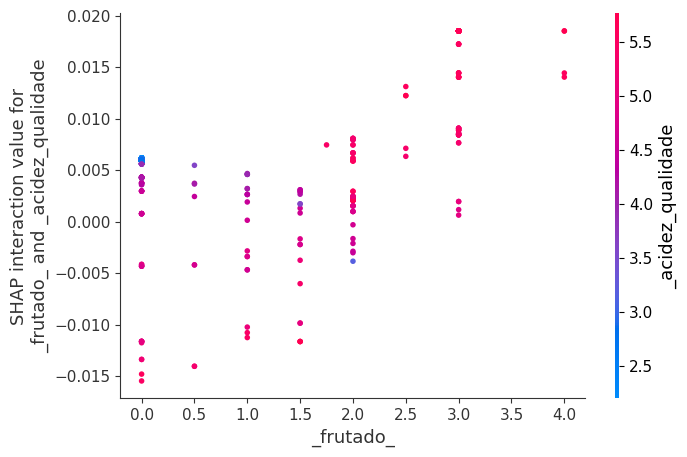

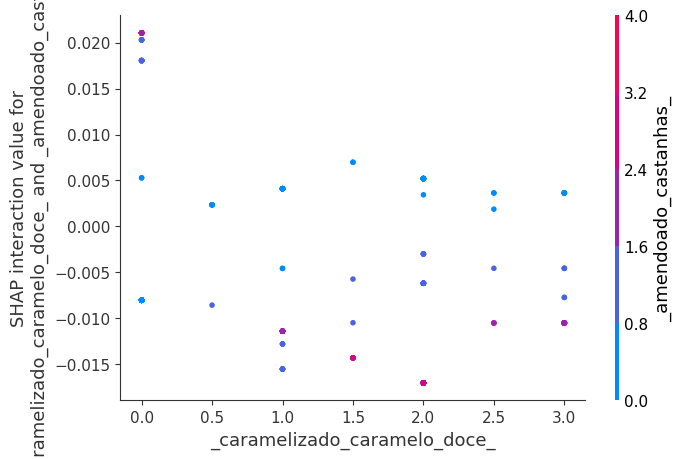

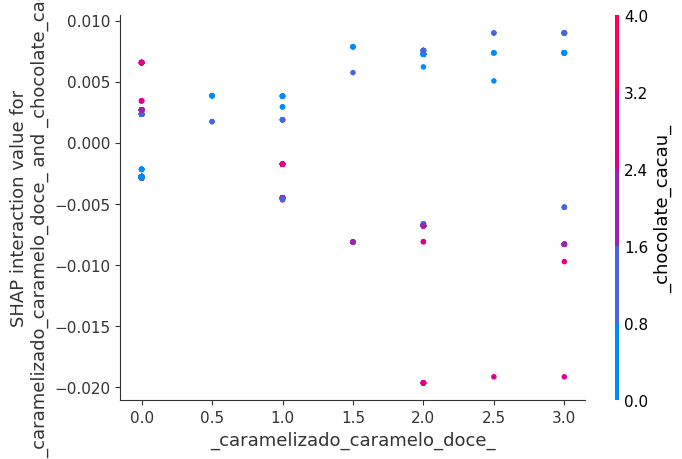

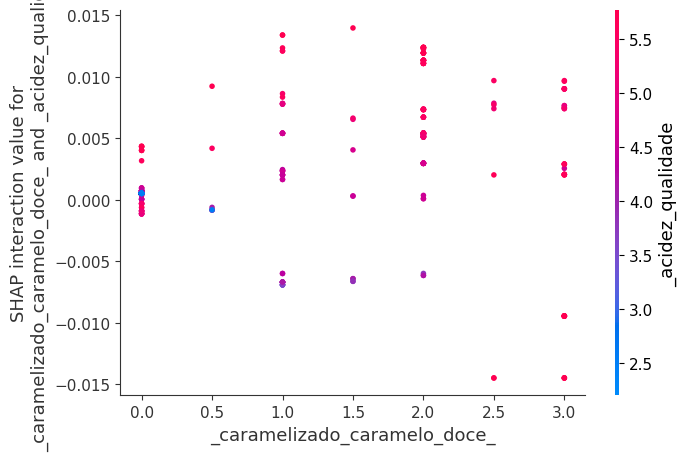

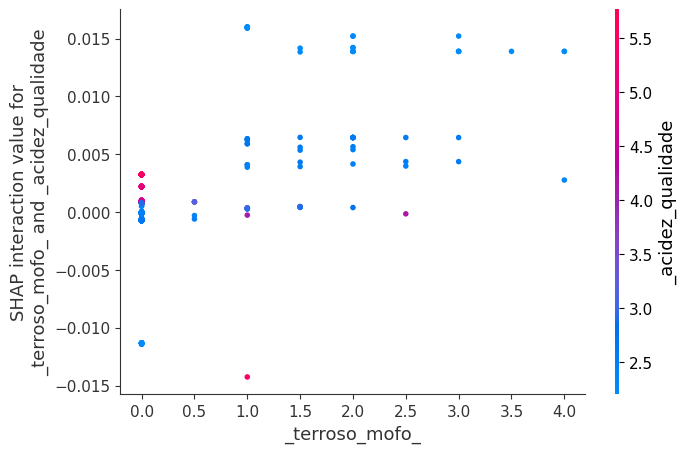

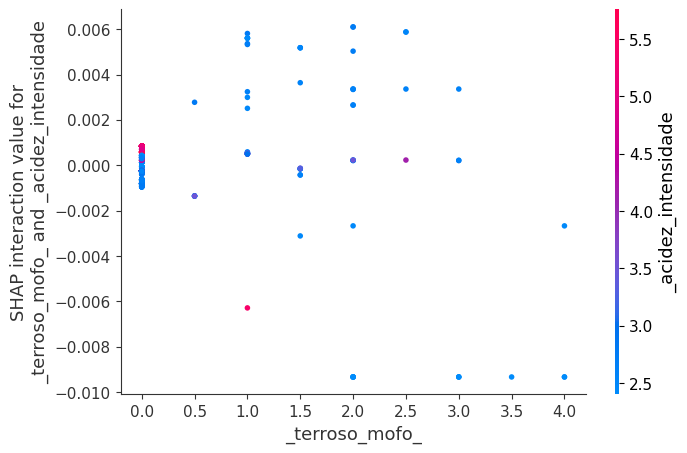

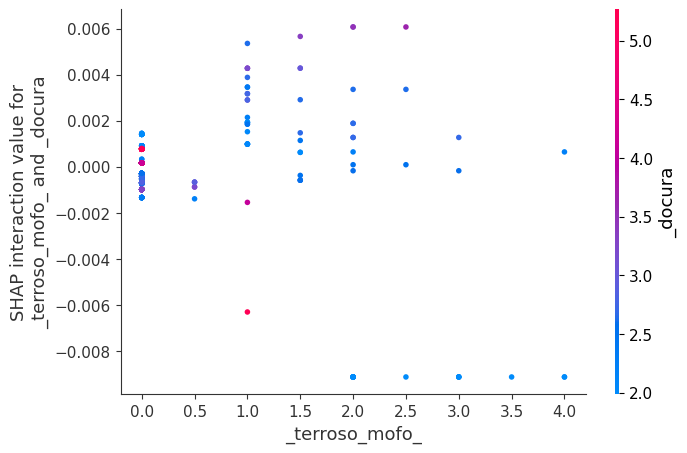

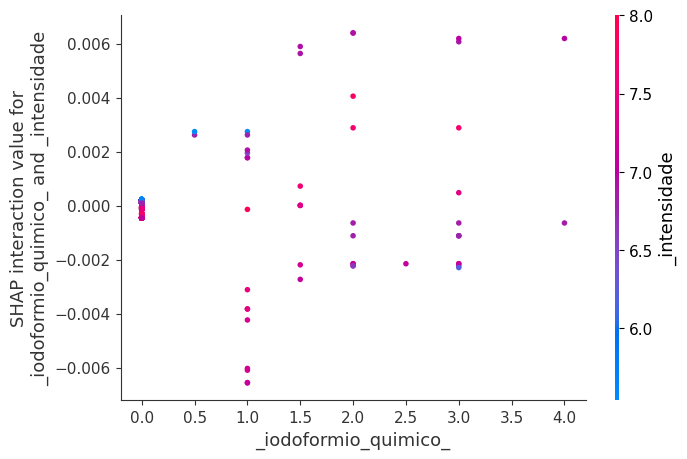

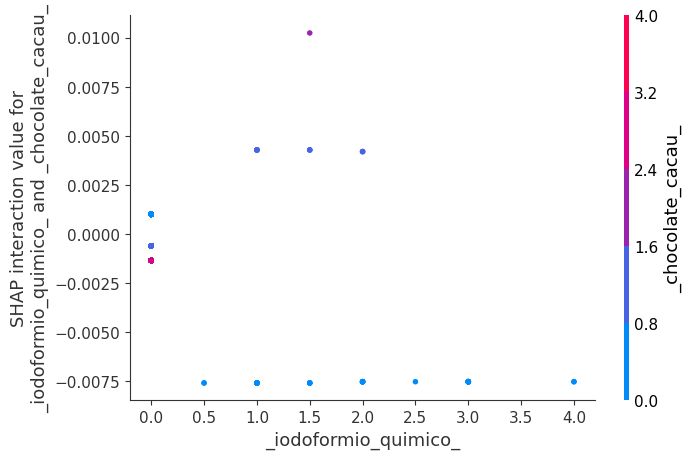

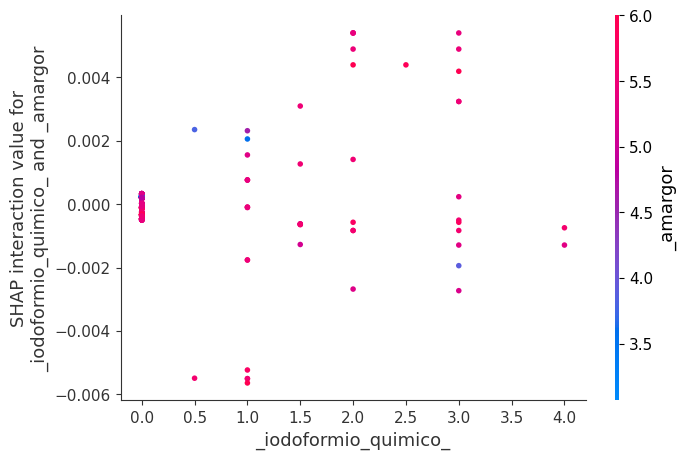

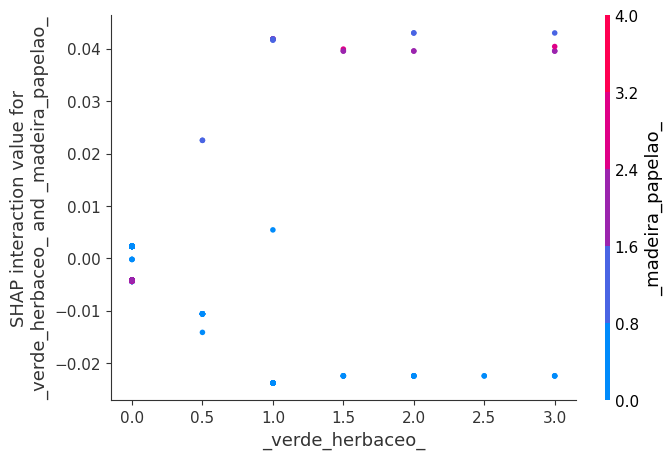

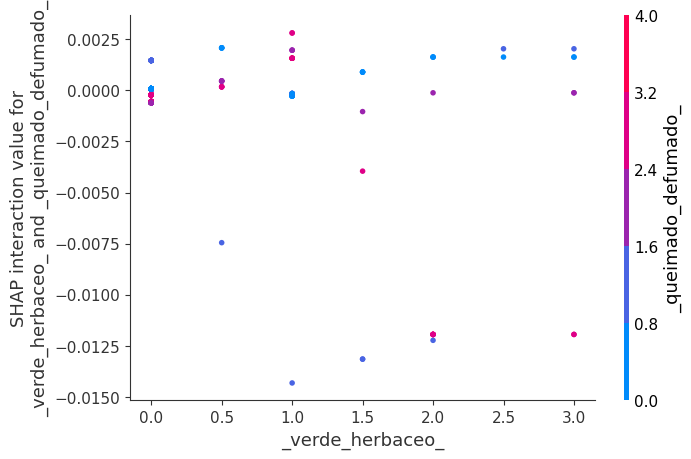

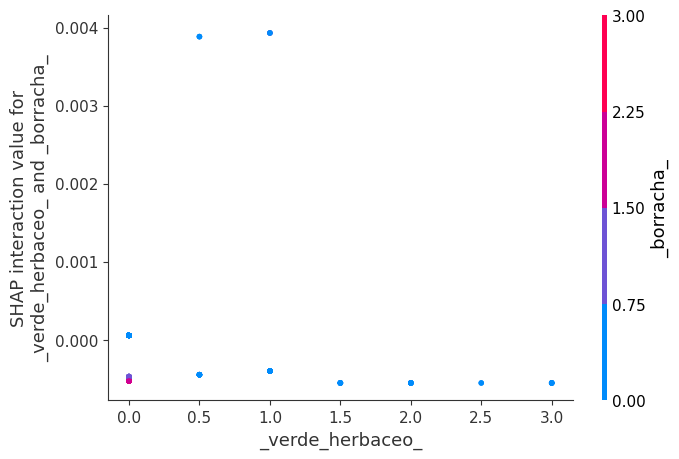

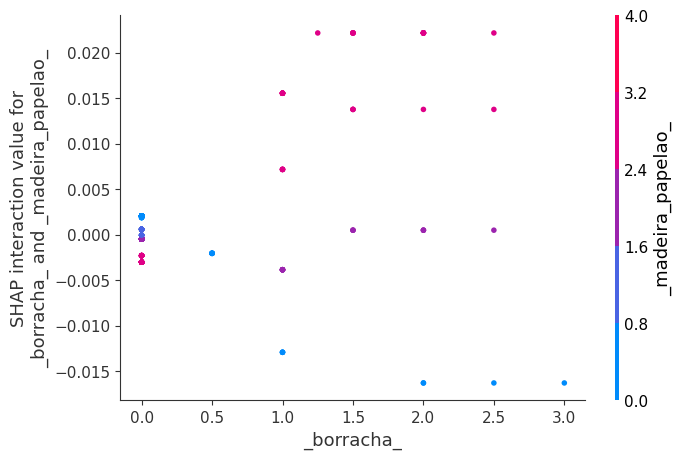

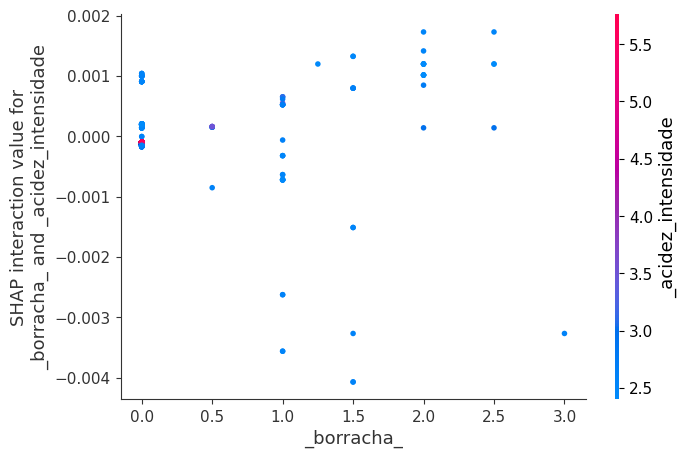

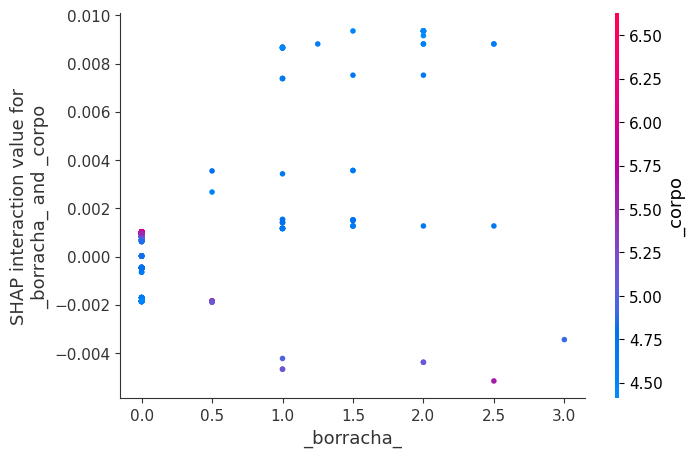

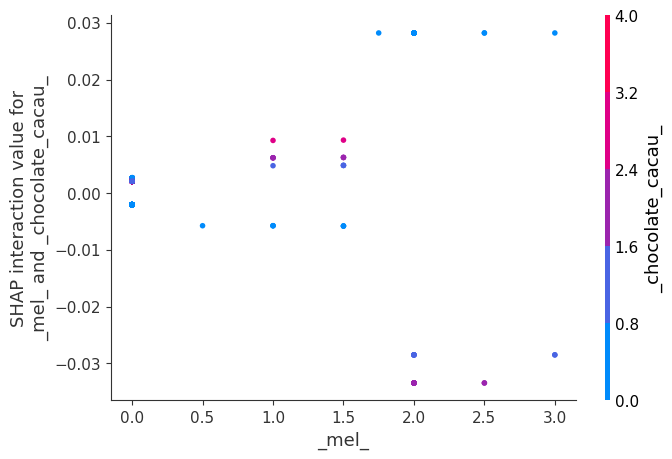

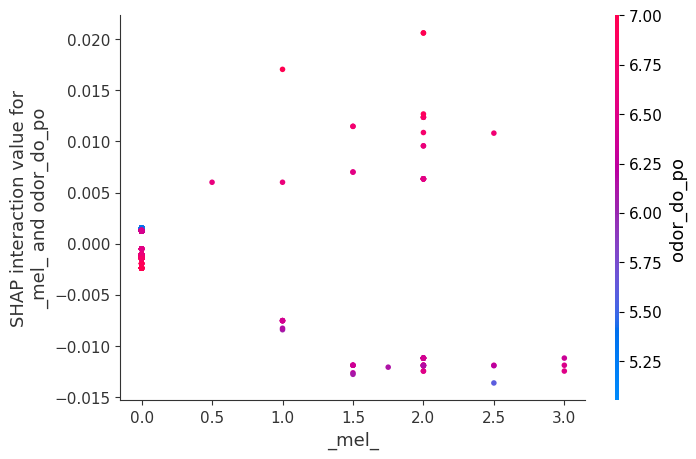

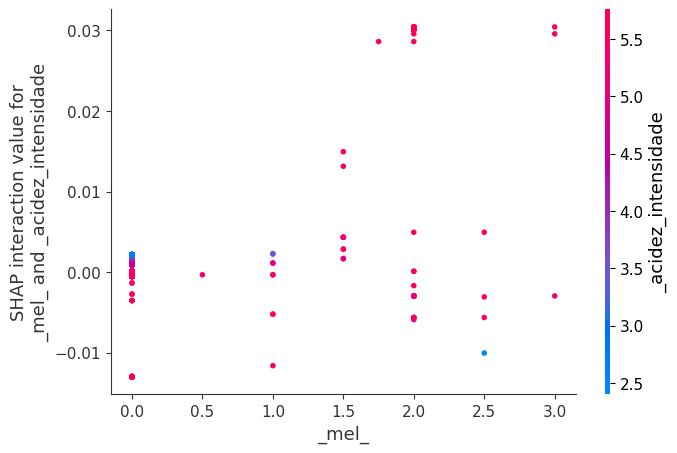

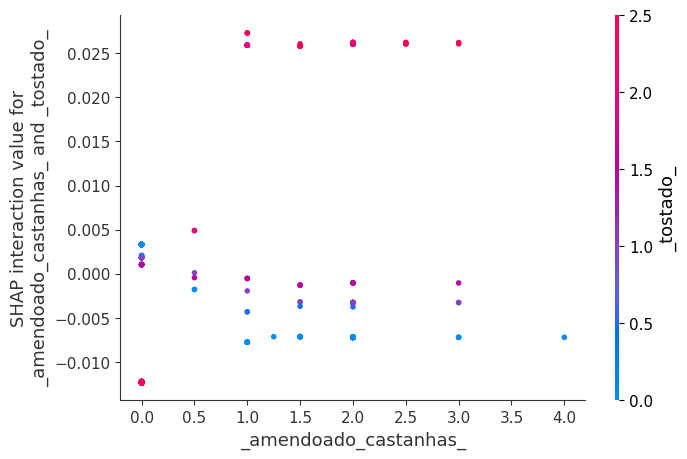

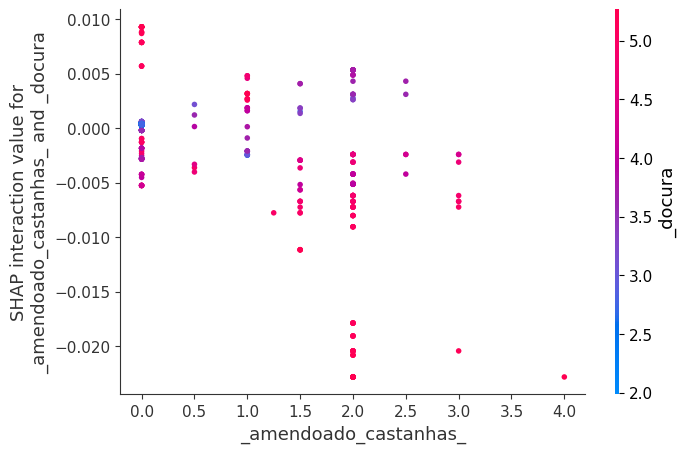

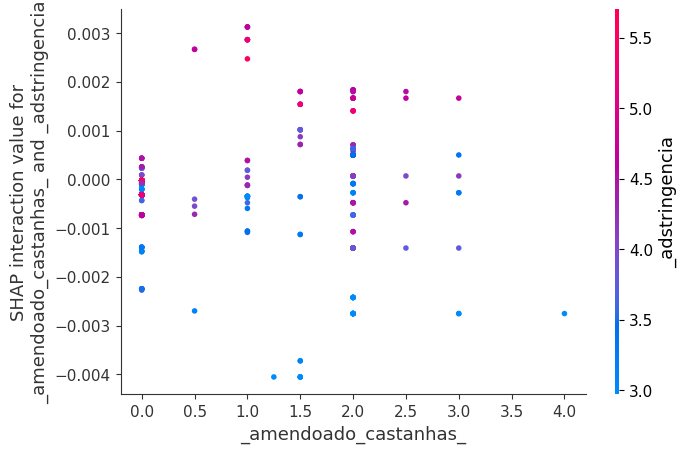

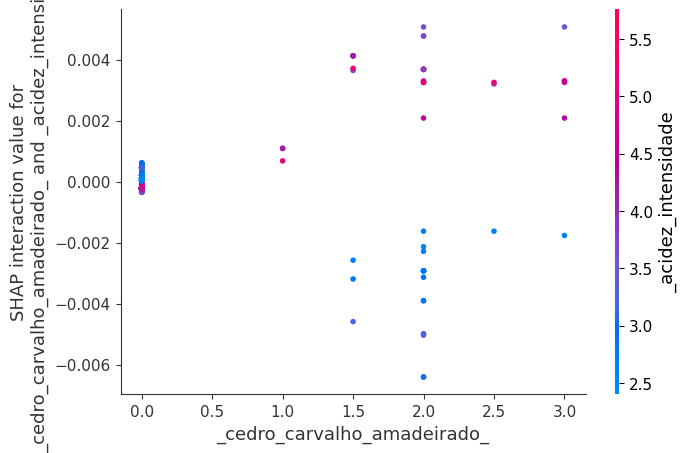

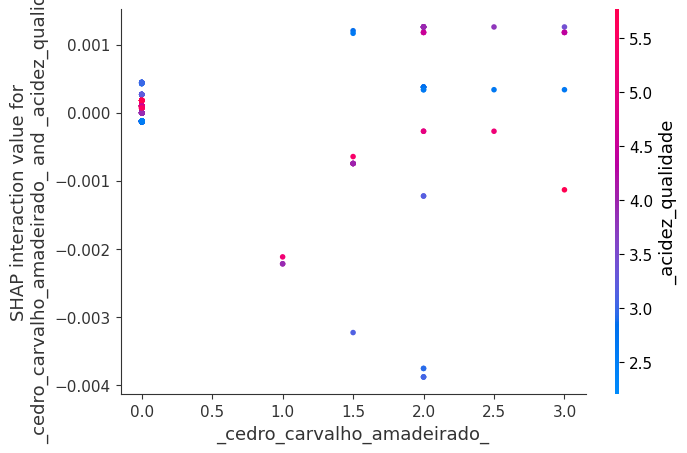

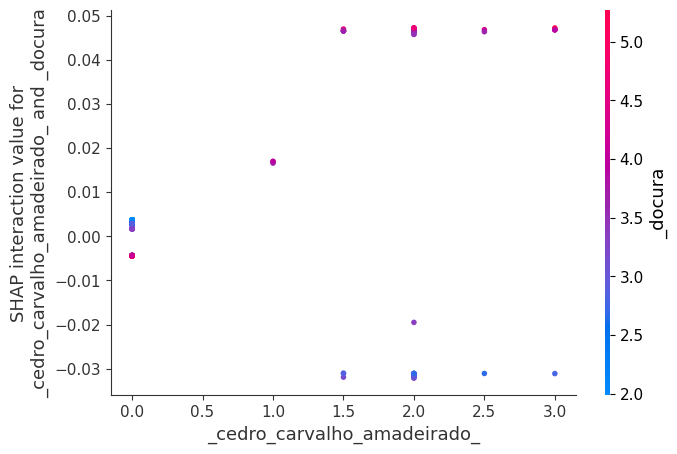

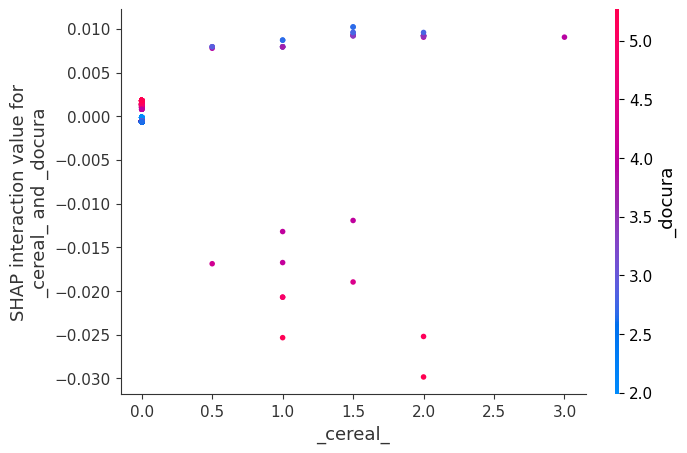

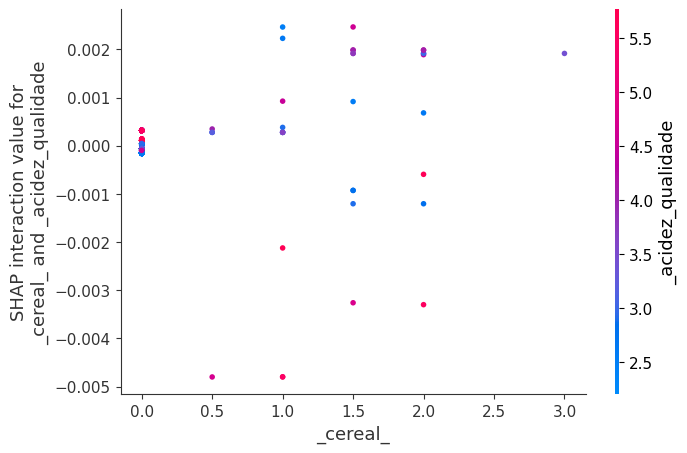

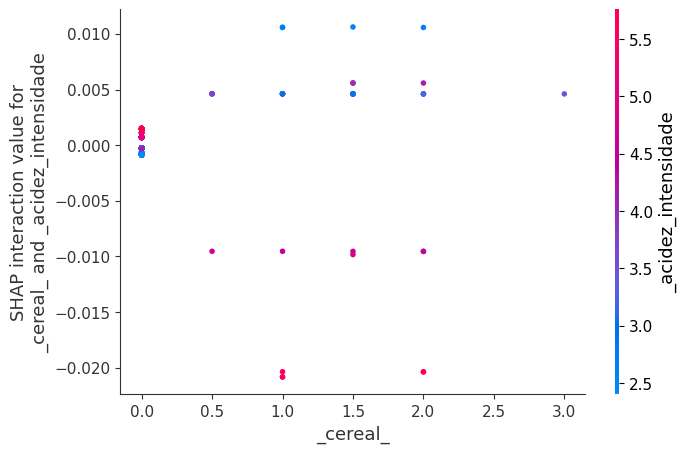

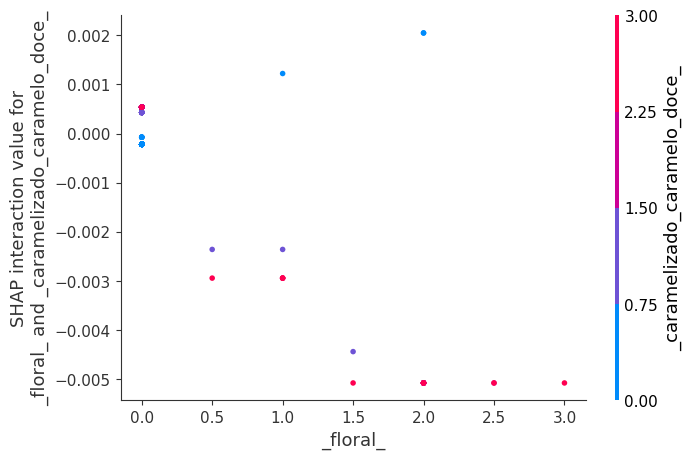

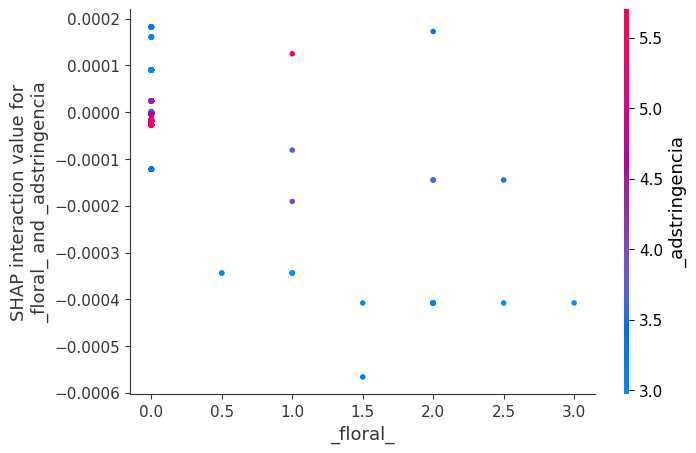

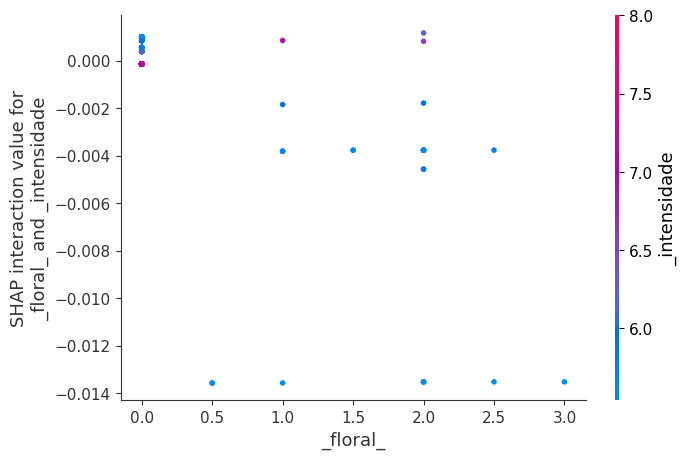

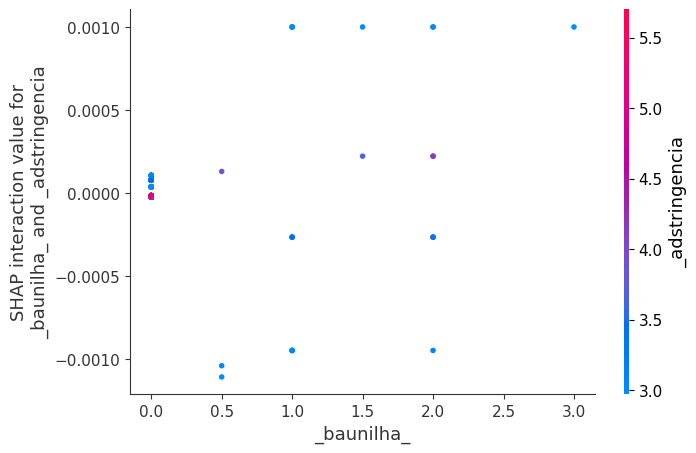

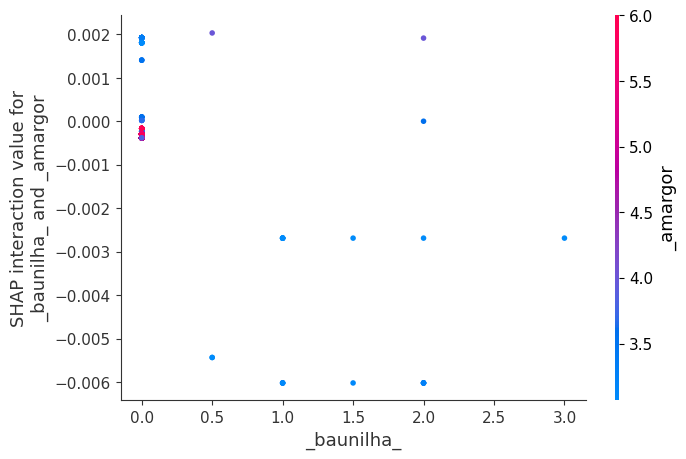

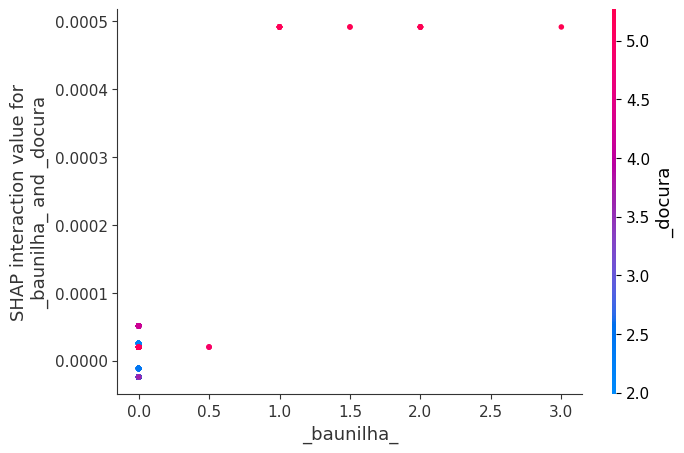

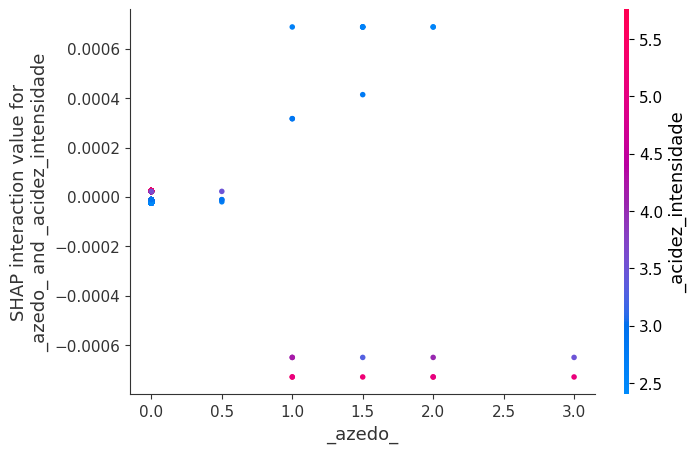

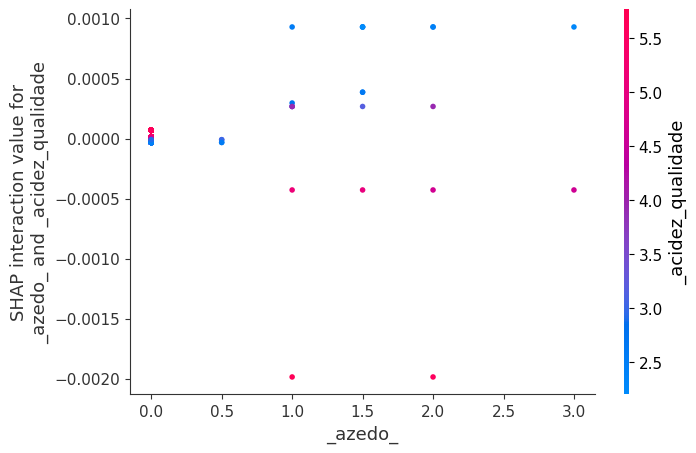

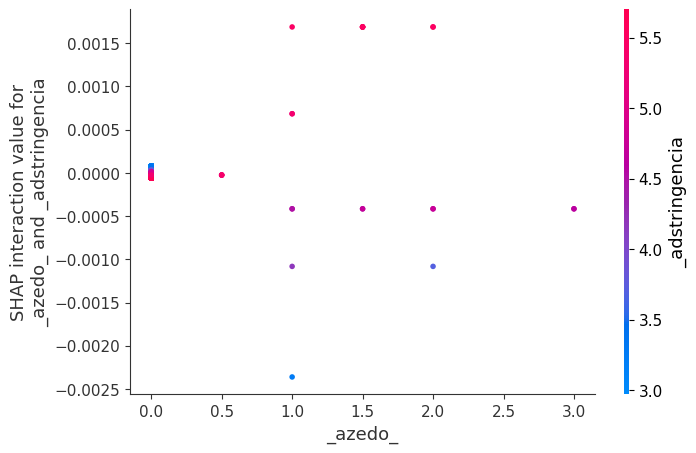

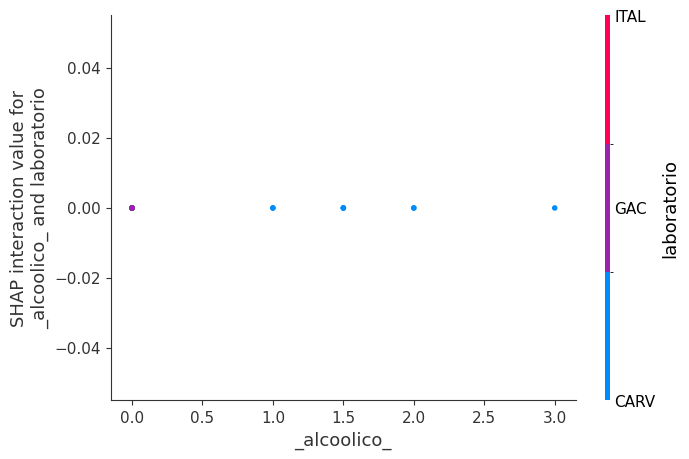

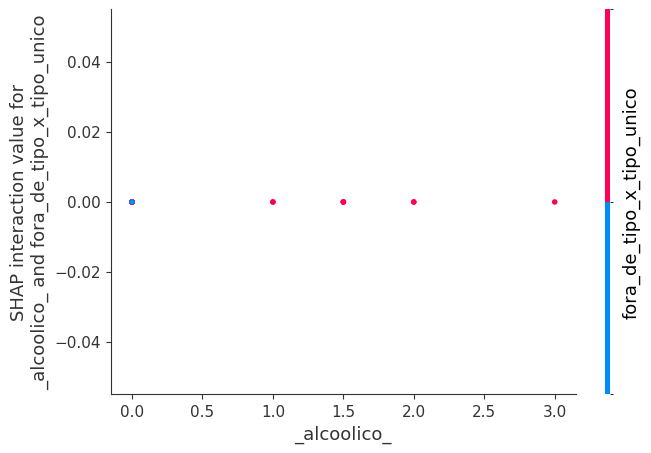

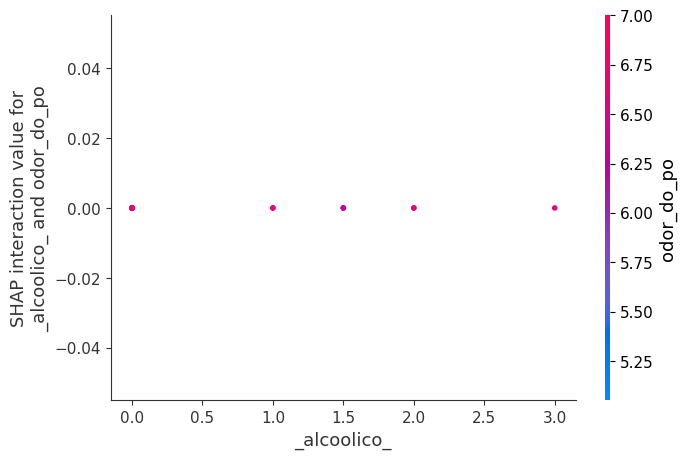

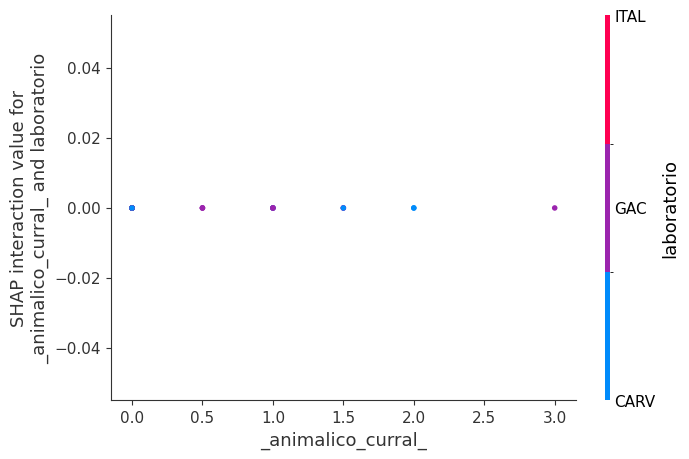

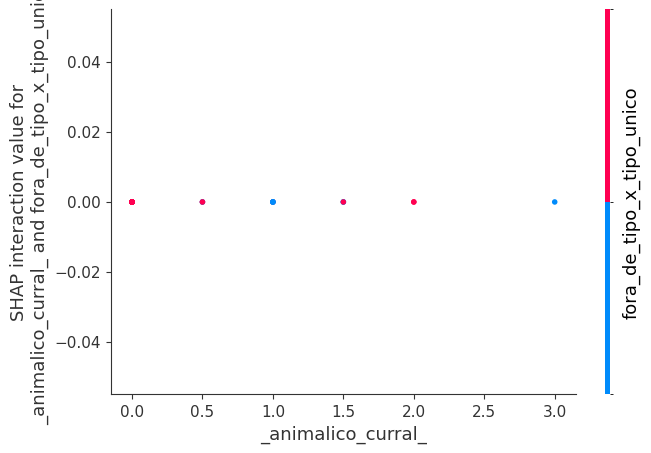

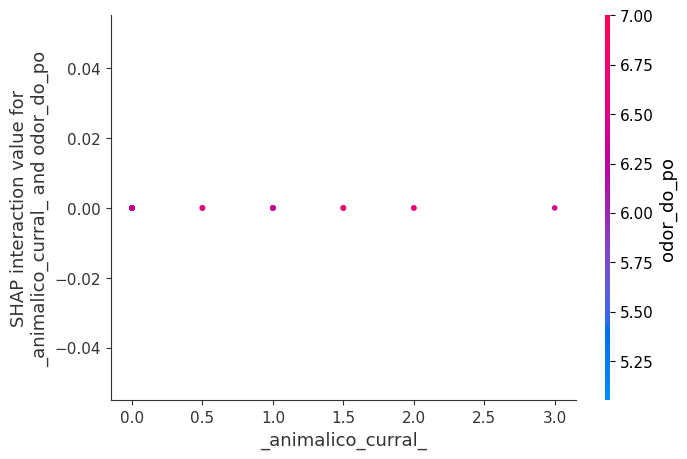

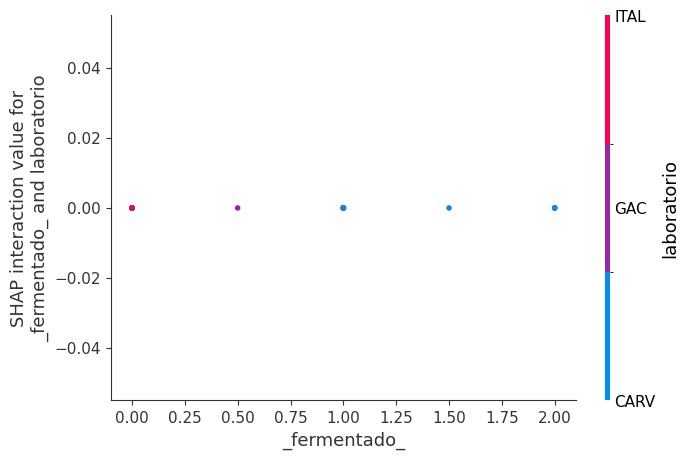

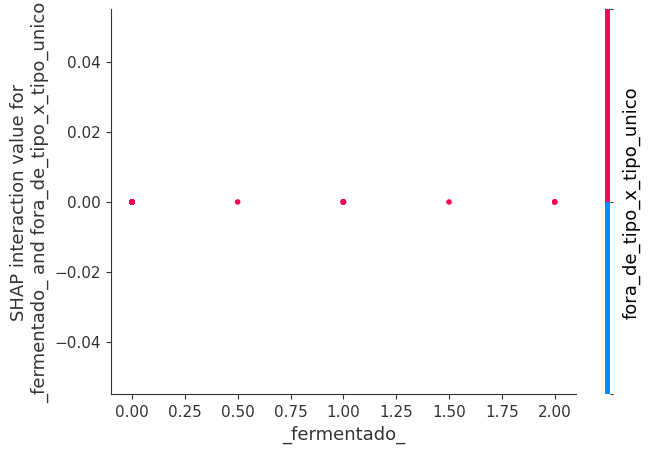

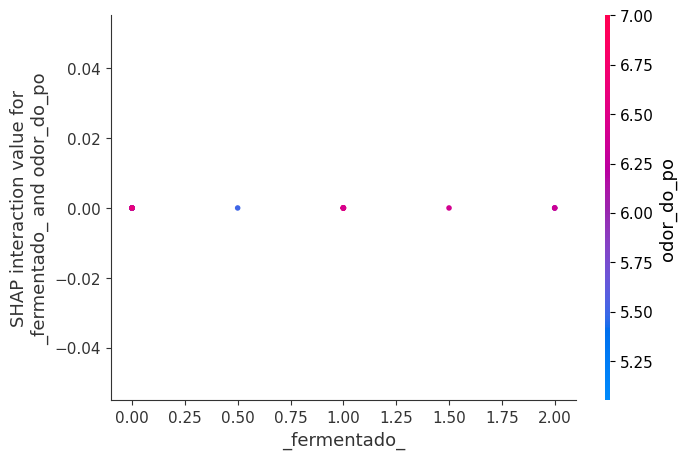

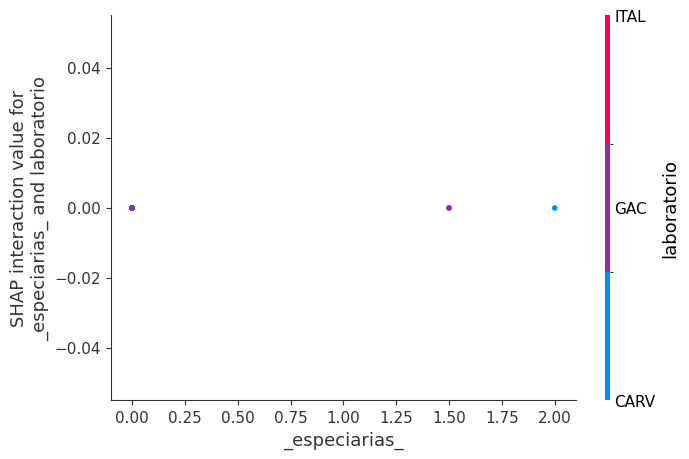

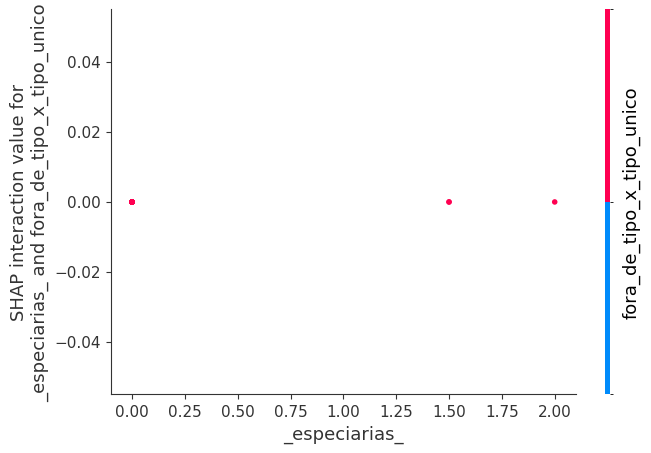

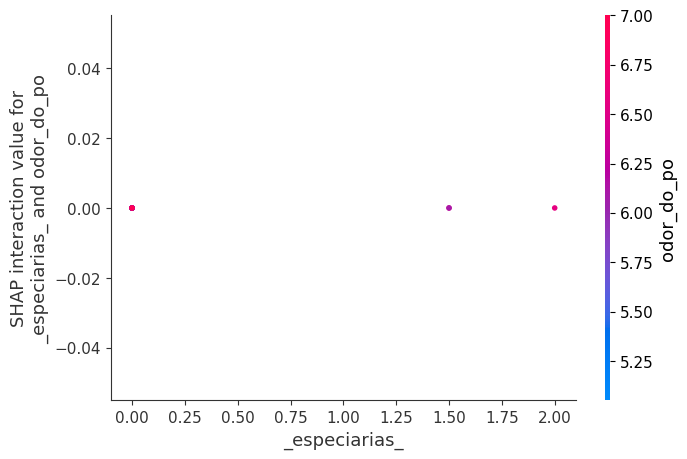

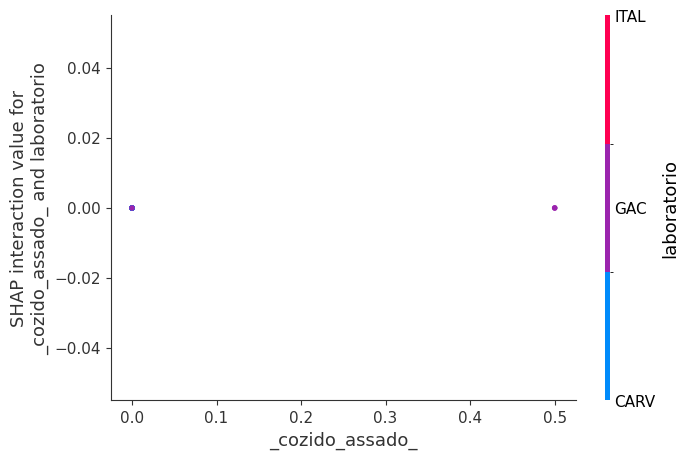

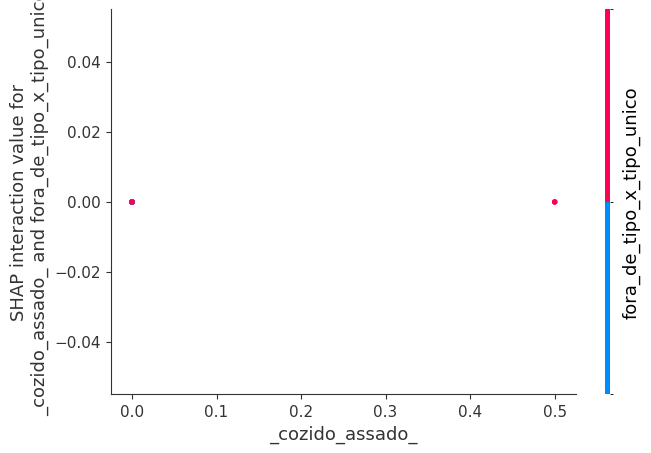

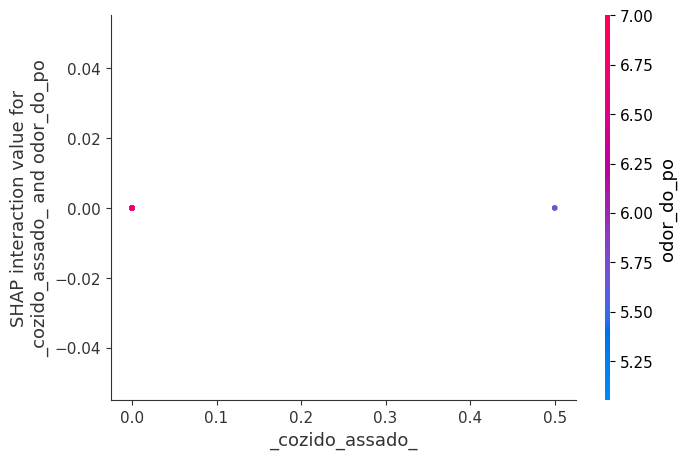

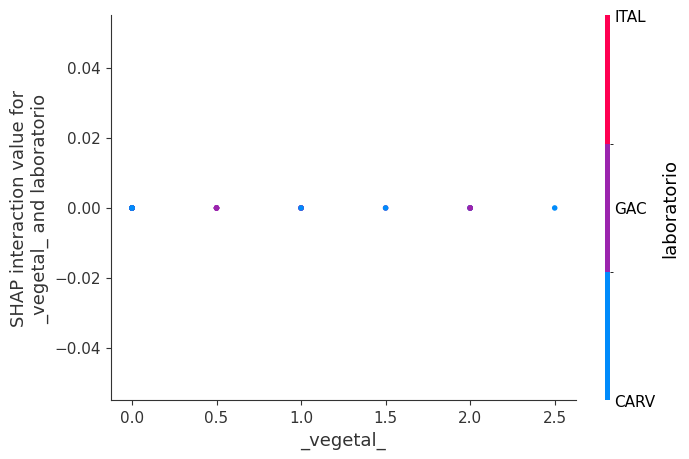

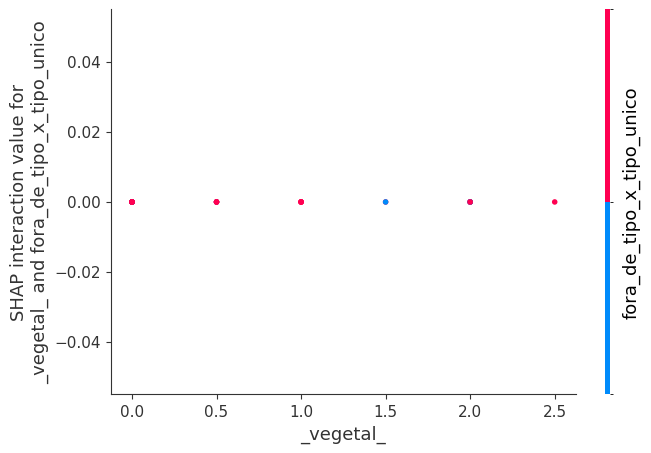

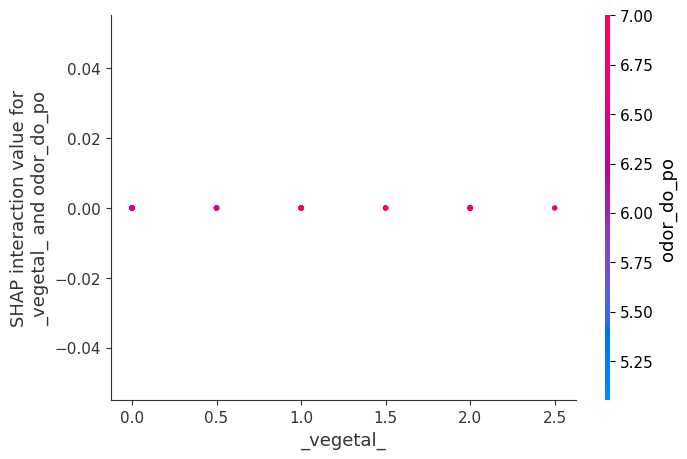

In [19]:


for col in int_imp.index.values:
   for i in range(3):
      index = int_order[col][i]
      int_var = trn_data.columns[index]
      
      shap.dependence_plot((col,int_var) , shap_interaction_values, trn_data)

In [20]:
int_var

'odor_do_po'

In [21]:
shap_vals

array([[-0.02620319, -0.03857714,  0.02081791, ...,  0.        ,
         0.00026203,  0.00061236],
       [-0.01435018, -0.05082543, -0.01849156, ...,  0.        ,
         0.00149566,  0.00616639],
       [-0.0342666 ,  0.00322962, -0.00083919, ...,  0.        ,
         0.01074947,  0.00136018],
       ...,
       [ 0.01007689, -0.00251183, -0.00275065, ...,  0.        ,
        -0.00053609,  0.00221042],
       [ 0.01649307, -0.00314163,  0.01523211, ...,  0.        ,
         0.000553  ,  0.00074501],
       [ 0.01295869, -0.00300772,  0.00369672, ...,  0.        ,
        -0.00745703,  0.00132602]])